In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-06 23:15:06,454] A new study created in memory with name: no-name-4362f99b-c090-4751-a1bd-90b13da39d3e
[I 2025-06-06 23:18:15,107] Trial 0 finished with value: 1.2148833751678467 and parameters: {'lr': 0.015870137354024316, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.23580548951538668}. Best is trial 0 with value: 1.2148833751678467.


Cross Validation Accuracies:
[1.1626516580581665, 1.3895384073257446, 1.0678739547729492, 1.1111034154891968, 1.3432494401931763]
Mean Cross Validation Accuracy:
1.2148833751678467
Standard Deviation of Cross Validation Accuracy:
0.12813463926365504


[I 2025-06-06 23:21:43,514] Trial 1 finished with value: 37.58169784545898 and parameters: {'lr': 0.35410673559783395, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.39602957335956135}. Best is trial 0 with value: 1.2148833751678467.


Cross Validation Accuracies:
[40.69301223754883, 38.289039611816406, 38.354305267333984, 42.38913345336914, 28.182998657226562]
Mean Cross Validation Accuracy:
37.58169784545898
Standard Deviation of Cross Validation Accuracy:
4.944178706403696


[I 2025-06-06 23:24:45,567] Trial 2 finished with value: 1.711449420452118 and parameters: {'lr': 0.5565200908392437, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4579947413913551}. Best is trial 0 with value: 1.2148833751678467.


Cross Validation Accuracies:
[2.1501731872558594, 0.9798274636268616, 2.0754287242889404, 0.9806205034255981, 2.37119722366333]
Mean Cross Validation Accuracy:
1.711449420452118
Standard Deviation of Cross Validation Accuracy:
0.6049145782162957


[I 2025-06-06 23:28:12,152] Trial 3 finished with value: 0.08408052921295166 and parameters: {'lr': 0.2431289902449045, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.45052108033676785}. Best is trial 3 with value: 0.08408052921295166.


Cross Validation Accuracies:
[0.05768886208534241, 0.13212424516677856, 0.07123496383428574, 0.09363577514886856, 0.06571879982948303]
Mean Cross Validation Accuracy:
0.08408052921295166
Standard Deviation of Cross Validation Accuracy:
0.026826043752934216


[I 2025-06-06 23:31:13,665] Trial 4 finished with value: 1.866661787033081 and parameters: {'lr': 0.022165282342246045, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4511635556872441}. Best is trial 3 with value: 0.08408052921295166.


Cross Validation Accuracies:
[1.8255980014801025, 1.7742691040039062, 1.847646713256836, 1.9492510557174683, 1.9365440607070923]
Mean Cross Validation Accuracy:
1.866661787033081
Standard Deviation of Cross Validation Accuracy:
0.06676636109248119


[I 2025-06-06 23:34:32,753] Trial 5 finished with value: 0.07898447066545486 and parameters: {'lr': 0.37932977771301574, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3711636904984288}. Best is trial 5 with value: 0.07898447066545486.


Cross Validation Accuracies:
[0.06921489536762238, 0.0944640189409256, 0.06555786728858948, 0.09667836129665375, 0.06900721043348312]
Mean Cross Validation Accuracy:
0.07898447066545486
Standard Deviation of Cross Validation Accuracy:
0.013623172772578443


[I 2025-06-06 23:37:59,022] Trial 6 finished with value: 0.37670980095863343 and parameters: {'lr': 0.7363413220899863, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.19977017581150466}. Best is trial 5 with value: 0.07898447066545486.


Cross Validation Accuracies:
[0.369971364736557, 0.4426273703575134, 0.29472044110298157, 0.38993939757347107, 0.38629043102264404]
Mean Cross Validation Accuracy:
0.37670980095863343
Standard Deviation of Cross Validation Accuracy:
0.04770659976717997


[I 2025-06-06 23:42:21,220] Trial 7 finished with value: 12.599039268493652 and parameters: {'lr': 0.9473969321905955, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4785973342404083}. Best is trial 5 with value: 0.07898447066545486.


Cross Validation Accuracies:
[23.325077056884766, 7.934683322906494, 6.800571441650391, 4.935051441192627, 19.999813079833984]
Mean Cross Validation Accuracy:
12.599039268493652
Standard Deviation of Cross Validation Accuracy:
7.535708255866917


[I 2025-06-06 23:45:18,699] Trial 8 finished with value: 0.07640623077750205 and parameters: {'lr': 0.0031524094924251346, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2989006420850796}. Best is trial 8 with value: 0.07640623077750205.


Cross Validation Accuracies:
[0.059396784752607346, 0.09747956693172455, 0.0727708488702774, 0.0940210223197937, 0.0583629310131073]
Mean Cross Validation Accuracy:
0.07640623077750205
Standard Deviation of Cross Validation Accuracy:
0.016628074451482594


[I 2025-06-06 23:48:00,887] Trial 9 finished with value: 0.0808917798101902 and parameters: {'lr': 0.5469265131824581, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.322794053569639}. Best is trial 8 with value: 0.07640623077750205.


Cross Validation Accuracies:
[0.06131630018353462, 0.10032173991203308, 0.06851447373628616, 0.09961573034524918, 0.07469065487384796]
Mean Cross Validation Accuracy:
0.0808917798101902
Standard Deviation of Cross Validation Accuracy:
0.01614286673385726


[I 2025-06-06 23:50:43,662] Trial 10 finished with value: 0.0760730654001236 and parameters: {'lr': 0.0018548912871559345, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12413915478186863}. Best is trial 10 with value: 0.0760730654001236.


Cross Validation Accuracies:
[0.0594298355281353, 0.09694326668977737, 0.07252383232116699, 0.09436335414648056, 0.057105038315057755]
Mean Cross Validation Accuracy:
0.0760730654001236
Standard Deviation of Cross Validation Accuracy:
0.016849214651230324


[I 2025-06-06 23:53:56,917] Trial 11 finished with value: 0.08510131910443305 and parameters: {'lr': 0.0012186296480343622, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11858450388318256}. Best is trial 10 with value: 0.0760730654001236.


Cross Validation Accuracies:
[0.059489648789167404, 0.09713523089885712, 0.07276585698127747, 0.09131643921136856, 0.10479941964149475]
Mean Cross Validation Accuracy:
0.08510131910443305
Standard Deviation of Cross Validation Accuracy:
0.016610714601831365


[I 2025-06-06 23:57:02,687] Trial 12 finished with value: 0.07730763405561447 and parameters: {'lr': 0.001358414894652693, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11007069135811887}. Best is trial 10 with value: 0.0760730654001236.


Cross Validation Accuracies:
[0.06277991086244583, 0.09706772118806839, 0.07243293523788452, 0.09642107039690018, 0.05783653259277344]
Mean Cross Validation Accuracy:
0.07730763405561447
Standard Deviation of Cross Validation Accuracy:
0.01655128825301348


[I 2025-06-06 23:59:46,101] Trial 13 finished with value: 0.07600506469607353 and parameters: {'lr': 0.004821886418073843, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2267732965117353}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.05901619419455528, 0.09764353185892105, 0.0726834237575531, 0.0937919020652771, 0.05689027160406113]
Mean Cross Validation Accuracy:
0.07600506469607353
Standard Deviation of Cross Validation Accuracy:
0.017027185199840776


[I 2025-06-07 00:03:35,373] Trial 14 finished with value: 0.07654324546456337 and parameters: {'lr': 0.005905352039920539, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.17420919077109345}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.05984361842274666, 0.09718946367502213, 0.07283107191324234, 0.09505978971719742, 0.05779228359460831]
Mean Cross Validation Accuracy:
0.07654324546456337
Standard Deviation of Cross Validation Accuracy:
0.01681300142338093


[I 2025-06-07 00:06:35,257] Trial 15 finished with value: 0.2550056278705597 and parameters: {'lr': 0.08034302672654486, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23496741555202455}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.2783188819885254, 0.2615646719932556, 0.23455406725406647, 0.24813298881053925, 0.25245752930641174]
Mean Cross Validation Accuracy:
0.2550056278705597
Standard Deviation of Cross Validation Accuracy:
0.014550059676608511


[I 2025-06-07 00:09:46,572] Trial 16 finished with value: 0.07611277177929879 and parameters: {'lr': 0.0063714526089655105, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16023239051397173}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.05963576212525368, 0.09728045761585236, 0.0720643475651741, 0.09415935724973679, 0.05742393434047699]
Mean Cross Validation Accuracy:
0.07611277177929879
Standard Deviation of Cross Validation Accuracy:
0.016798240392306384


[I 2025-06-07 00:12:40,167] Trial 17 finished with value: 0.09323968067765236 and parameters: {'lr': 0.0028924213537950697, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26911283901432737}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.05531328544020653, 0.10908146947622299, 0.1283363550901413, 0.09909869730472565, 0.07436859607696533]
Mean Cross Validation Accuracy:
0.09323968067765236
Standard Deviation of Cross Validation Accuracy:
0.025735563691919927


[I 2025-06-07 00:16:21,667] Trial 18 finished with value: 0.2108177661895752 and parameters: {'lr': 0.05414209083694229, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14490572126440202}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.21105171740055084, 0.21423135697841644, 0.21938370168209076, 0.23076392710208893, 0.178658127784729]
Mean Cross Validation Accuracy:
0.2108177661895752
Standard Deviation of Cross Validation Accuracy:
0.017419381525089032


[I 2025-06-07 00:19:13,477] Trial 19 finished with value: 0.0792340762913227 and parameters: {'lr': 0.010388686800462036, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.21016754754100686}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.06279171258211136, 0.09600099921226501, 0.06971967965364456, 0.10547535121440887, 0.06218263879418373]
Mean Cross Validation Accuracy:
0.0792340762913227
Standard Deviation of Cross Validation Accuracy:
0.018007558425670596


[I 2025-06-07 00:22:09,803] Trial 20 finished with value: 0.0801318846642971 and parameters: {'lr': 0.002507510363268742, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2596322027481395}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.08651913702487946, 0.10095586627721786, 0.06722664833068848, 0.09644661098718643, 0.04951116070151329]
Mean Cross Validation Accuracy:
0.0801318846642971
Standard Deviation of Cross Validation Accuracy:
0.01920822406551475


[I 2025-06-07 00:24:55,188] Trial 21 finished with value: 0.07630462646484375 and parameters: {'lr': 0.005876986857244868, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15526427115748243}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.06040273979306221, 0.09684698283672333, 0.0721399337053299, 0.09459778666496277, 0.05753568932414055]
Mean Cross Validation Accuracy:
0.07630462646484375
Standard Deviation of Cross Validation Accuracy:
0.01660792450796618


[I 2025-06-07 00:27:54,263] Trial 22 finished with value: 0.07607182562351227 and parameters: {'lr': 0.006771612352957751, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17698417105096992}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.06033116579055786, 0.09705210477113724, 0.07121702283620834, 0.0948726162314415, 0.0568862184882164]
Mean Cross Validation Accuracy:
0.07607182562351227
Standard Deviation of Cross Validation Accuracy:
0.01692965944031823


[I 2025-06-07 00:30:49,928] Trial 23 finished with value: 0.07637841254472733 and parameters: {'lr': 0.001896022467355124, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19468001418608466}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.05970452353358269, 0.09718674421310425, 0.07280213385820389, 0.09438464790582657, 0.057814013212919235]
Mean Cross Validation Accuracy:
0.07637841254472733
Standard Deviation of Cross Validation Accuracy:
0.01668925669555698


[I 2025-06-07 00:34:21,306] Trial 24 finished with value: 0.07647429406642914 and parameters: {'lr': 0.009736069364403731, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10347124542539086}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.05935989320278168, 0.09705398976802826, 0.0732557624578476, 0.09449909627437592, 0.058202728629112244]
Mean Cross Validation Accuracy:
0.07647429406642914
Standard Deviation of Cross Validation Accuracy:
0.016646495943430432


[I 2025-06-07 00:38:26,981] Trial 25 finished with value: 0.07635812163352966 and parameters: {'lr': 0.004205516905723291, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13210484048921795}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.06007655709981918, 0.09739436954259872, 0.07247111201286316, 0.09406308084726334, 0.05778548866510391]
Mean Cross Validation Accuracy:
0.07635812163352966
Standard Deviation of Cross Validation Accuracy:
0.016620049276029076


[I 2025-06-07 00:41:24,787] Trial 26 finished with value: 0.12789258360862732 and parameters: {'lr': 0.03554173167714459, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17517625837129505}. Best is trial 13 with value: 0.07600506469607353.


Cross Validation Accuracies:
[0.13845965266227722, 0.129379004240036, 0.13067573308944702, 0.10385943949222565, 0.1370890885591507]
Mean Cross Validation Accuracy:
0.12789258360862732
Standard Deviation of Cross Validation Accuracy:
0.012520271843178192


[I 2025-06-07 00:44:28,930] Trial 27 finished with value: 0.07572503760457039 and parameters: {'lr': 0.011370047679765204, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2216755550465241}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.05908292159438133, 0.09857888519763947, 0.07000976800918579, 0.09345448762178421, 0.057499125599861145]
Mean Cross Validation Accuracy:
0.07572503760457039
Standard Deviation of Cross Validation Accuracy:
0.017195580525053728


[I 2025-06-07 00:47:25,626] Trial 28 finished with value: 0.07858610674738883 and parameters: {'lr': 0.012985480861640005, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.29381985155668844}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.05783919617533684, 0.09707430750131607, 0.07489889860153198, 0.09850864112377167, 0.06460949033498764]
Mean Cross Validation Accuracy:
0.07858610674738883
Standard Deviation of Cross Validation Accuracy:
0.01660178635948957


[I 2025-06-07 00:51:23,569] Trial 29 finished with value: 0.14525256752967836 and parameters: {'lr': 0.02327824514808735, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23057618162771432}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.15565705299377441, 0.1923769861459732, 0.166815847158432, 0.12815898656845093, 0.08325396478176117]
Mean Cross Validation Accuracy:
0.14525256752967836
Standard Deviation of Cross Validation Accuracy:
0.03722890390225392


[I 2025-06-07 00:54:47,293] Trial 30 finished with value: 13.164505004882812 and parameters: {'lr': 0.13710809146641842, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.33357196544945955}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[15.309794425964355, 9.952035903930664, 15.99439811706543, 14.11197566986084, 10.454320907592773]
Mean Cross Validation Accuracy:
13.164505004882812
Standard Deviation of Cross Validation Accuracy:
2.4969308341783534


[I 2025-06-07 00:58:17,796] Trial 31 finished with value: 0.07615147605538368 and parameters: {'lr': 0.009003728540915782, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26130863216446737}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.06021249294281006, 0.09747680276632309, 0.07135522365570068, 0.09503161162137985, 0.05668124929070473]
Mean Cross Validation Accuracy:
0.07615147605538368
Standard Deviation of Cross Validation Accuracy:
0.017131106376011403


[I 2025-06-07 01:01:39,251] Trial 32 finished with value: 0.09047711938619614 and parameters: {'lr': 0.018157410902175042, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21673340966002738}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.07423746585845947, 0.11262201517820358, 0.09832504391670227, 0.09370920807123184, 0.07349186390638351]
Mean Cross Validation Accuracy:
0.09047711938619614
Standard Deviation of Cross Validation Accuracy:
0.014930893990372843


[I 2025-06-07 01:05:03,686] Trial 33 finished with value: 0.07643744722008705 and parameters: {'lr': 0.004532610766809329, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18452563459719903}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.059547122567892075, 0.09711349755525589, 0.07191561162471771, 0.09520703554153442, 0.058403968811035156]
Mean Cross Validation Accuracy:
0.07643744722008705
Standard Deviation of Cross Validation Accuracy:
0.016797219476787726


[I 2025-06-07 01:08:49,592] Trial 34 finished with value: 0.07640364989638329 and parameters: {'lr': 0.002001650874292463, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13083297655493684}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.0600469745695591, 0.09704741835594177, 0.07265105098485947, 0.09432674199342728, 0.057946063578128815]
Mean Cross Validation Accuracy:
0.07640364989638329
Standard Deviation of Cross Validation Accuracy:
0.016551179568627162


[I 2025-06-07 01:12:39,232] Trial 35 finished with value: 0.07691927030682563 and parameters: {'lr': 0.003999808327582167, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2462935050918163}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.031067989766597748, 0.11488372832536697, 0.07281633466482162, 0.10391578078269958, 0.06191251799464226]
Mean Cross Validation Accuracy:
0.07691927030682563
Standard Deviation of Cross Validation Accuracy:
0.03004825543533564


[I 2025-06-07 01:15:40,976] Trial 36 finished with value: 0.08317662850022316 and parameters: {'lr': 0.001054404122253622, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21626376181980572}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.07683753222227097, 0.10529500991106033, 0.07608536630868912, 0.09664904326200485, 0.06101619079709053]
Mean Cross Validation Accuracy:
0.08317662850022316
Standard Deviation of Cross Validation Accuracy:
0.015825826335666586


[I 2025-06-07 01:18:48,726] Trial 37 finished with value: 0.07939886376261711 and parameters: {'lr': 0.031645292243630115, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.41911360433424544}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.06249302998185158, 0.09729067981243134, 0.07980124652385712, 0.09240899980068207, 0.06500036269426346]
Mean Cross Validation Accuracy:
0.07939886376261711
Standard Deviation of Cross Validation Accuracy:
0.014019034788559046


[I 2025-06-07 01:21:56,465] Trial 38 finished with value: 0.07632958814501763 and parameters: {'lr': 0.007407682476324682, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1590635034528951}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.05996843799948692, 0.09683751314878464, 0.0736575722694397, 0.09435250610113144, 0.05683191120624542]
Mean Cross Validation Accuracy:
0.07632958814501763
Standard Deviation of Cross Validation Accuracy:
0.016735512352752224


[I 2025-06-07 01:25:24,794] Trial 39 finished with value: 0.2909306585788727 and parameters: {'lr': 0.014925841632544906, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.191419629017342}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.30055472254753113, 0.2952251434326172, 0.2977757751941681, 0.15076425671577454, 0.41033339500427246]
Mean Cross Validation Accuracy:
0.2909306585788727
Standard Deviation of Cross Validation Accuracy:
0.08253672456068253


[I 2025-06-07 01:28:50,478] Trial 40 finished with value: 0.32190086841583254 and parameters: {'lr': 0.001986991738524686, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2789774098019885}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.26658129692077637, 0.2827511727809906, 0.2551330029964447, 0.4720211923122406, 0.3330176770687103]
Mean Cross Validation Accuracy:
0.32190086841583254
Standard Deviation of Cross Validation Accuracy:
0.0796374241079482


[I 2025-06-07 01:32:13,177] Trial 41 finished with value: 0.07642133012413979 and parameters: {'lr': 0.006194314037824383, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16219927228557118}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.060064397752285004, 0.09744756668806076, 0.07259213924407959, 0.09500740468502045, 0.05699514225125313]
Mean Cross Validation Accuracy:
0.07642133012413979
Standard Deviation of Cross Validation Accuracy:
0.017012545408084227


[I 2025-06-07 01:35:56,569] Trial 42 finished with value: 0.07634399458765984 and parameters: {'lr': 0.0037659439264524815, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13414924291878133}. Best is trial 27 with value: 0.07572503760457039.


Cross Validation Accuracies:
[0.05926388129591942, 0.0970671996474266, 0.07287385314702988, 0.09464995563030243, 0.05786508321762085]
Mean Cross Validation Accuracy:
0.07634399458765984
Standard Deviation of Cross Validation Accuracy:
0.016791675048918212


[I 2025-06-07 01:39:33,631] Trial 43 finished with value: 0.0752818800508976 and parameters: {'lr': 0.01186534649909399, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17054815536605136}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.05921115353703499, 0.0967479720711708, 0.0695582702755928, 0.09464416652917862, 0.05624783784151077]
Mean Cross Validation Accuracy:
0.0752818800508976
Standard Deviation of Cross Validation Accuracy:
0.017256963618562285


[I 2025-06-07 01:42:54,679] Trial 44 finished with value: 0.09041630923748016 and parameters: {'lr': 0.0210411816668956, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2122243040621053}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.08680640906095505, 0.11593259871006012, 0.07800167798995972, 0.08743942528963089, 0.08390143513679504]
Mean Cross Validation Accuracy:
0.09041630923748016
Standard Deviation of Cross Validation Accuracy:
0.013187425065808884


[I 2025-06-07 01:46:38,910] Trial 45 finished with value: 0.07645501270890236 and parameters: {'lr': 0.011603053376127312, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3311277249089313}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.06099418178200722, 0.09809902310371399, 0.07265275716781616, 0.0927962139248848, 0.05773288756608963]
Mean Cross Validation Accuracy:
0.07645501270890236
Standard Deviation of Cross Validation Accuracy:
0.01636771488733133


[I 2025-06-07 01:50:14,924] Trial 46 finished with value: 0.07645361721515656 and parameters: {'lr': 0.008045284618196147, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24242741331571324}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.06106707826256752, 0.09751245379447937, 0.07247644662857056, 0.09362336993217468, 0.057588737457990646]
Mean Cross Validation Accuracy:
0.07645361721515656
Standard Deviation of Cross Validation Accuracy:
0.01641171631185994


[I 2025-06-07 01:55:14,778] Trial 47 finished with value: 1.5751842260360718 and parameters: {'lr': 0.04256512841769899, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1748313923429289}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[1.2887648344039917, 1.9605426788330078, 1.4091240167617798, 1.6039247512817383, 1.6135648488998413]
Mean Cross Validation Accuracy:
1.5751842260360718
Standard Deviation of Cross Validation Accuracy:
0.22821581371673988


[I 2025-06-07 01:58:53,470] Trial 48 finished with value: 0.09864541739225388 and parameters: {'lr': 0.0015362536216083913, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.11852213624124164}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.08196531236171722, 0.11813066899776459, 0.09457491338253021, 0.10175848752260208, 0.09679770469665527]
Mean Cross Validation Accuracy:
0.09864541739225388
Standard Deviation of Cross Validation Accuracy:
0.011726680559262376


[I 2025-06-07 02:02:22,255] Trial 49 finished with value: 0.31655206680297854 and parameters: {'lr': 0.0024843921632705457, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10071168521383228}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.2830512225627899, 0.26954323053359985, 0.29696083068847656, 0.43204259872436523, 0.301162451505661]
Mean Cross Validation Accuracy:
0.31655206680297854
Standard Deviation of Cross Validation Accuracy:
0.05880621907108986


[I 2025-06-07 02:05:38,669] Trial 50 finished with value: 0.07629619762301446 and parameters: {'lr': 0.005045468442986865, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14875506668562563}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.059047747403383255, 0.0972454622387886, 0.07260413467884064, 0.09442858397960663, 0.058155059814453125]
Mean Cross Validation Accuracy:
0.07629619762301446
Standard Deviation of Cross Validation Accuracy:
0.016780323999723647


[I 2025-06-07 02:09:37,289] Trial 51 finished with value: 0.07614401653409004 and parameters: {'lr': 0.007027713908397536, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1692839199141708}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.05928385257720947, 0.09719611704349518, 0.07338491827249527, 0.09339313954114914, 0.05746205523610115]
Mean Cross Validation Accuracy:
0.07614401653409004
Standard Deviation of Cross Validation Accuracy:
0.016622975727470315


[I 2025-06-07 02:13:20,480] Trial 52 finished with value: 0.07669249773025513 and parameters: {'lr': 0.0030510679465733425, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2006879252533963}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.060539234429597855, 0.0973198190331459, 0.072873055934906, 0.09434960037469864, 0.05838077887892723]
Mean Cross Validation Accuracy:
0.07669249773025513
Standard Deviation of Cross Validation Accuracy:
0.016420077686220634


[I 2025-06-07 02:16:55,871] Trial 53 finished with value: 0.07852325588464737 and parameters: {'lr': 0.014845090712834588, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1374922609968116}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.05853530019521713, 0.0969548150897026, 0.07309103012084961, 0.09440408647060394, 0.06963104754686356]
Mean Cross Validation Accuracy:
0.07852325588464737
Standard Deviation of Cross Validation Accuracy:
0.0148325451177022


[I 2025-06-07 02:20:30,115] Trial 54 finished with value: 0.07619514092803001 and parameters: {'lr': 0.005611950485387119, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18498005626822522}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.059155624359846115, 0.09715455770492554, 0.07198569178581238, 0.09431106597185135, 0.05836876481771469]
Mean Cross Validation Accuracy:
0.07619514092803001
Standard Deviation of Cross Validation Accuracy:
0.01669328106757754


[I 2025-06-07 02:24:14,123] Trial 55 finished with value: 0.11786789894104004 and parameters: {'lr': 0.024730848847705593, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22575225394376447}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.10657186806201935, 0.1346263587474823, 0.1320374310016632, 0.12000283598899841, 0.09610100090503693]
Mean Cross Validation Accuracy:
0.11786789894104004
Standard Deviation of Cross Validation Accuracy:
0.014748408279061567


[I 2025-06-07 02:27:54,886] Trial 56 finished with value: 0.07669839784502983 and parameters: {'lr': 0.010066896366713145, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11732307850410481}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.05981216952204704, 0.0972134917974472, 0.07330914586782455, 0.09408466517925262, 0.05907251685857773]
Mean Cross Validation Accuracy:
0.07669839784502983
Standard Deviation of Cross Validation Accuracy:
0.016312294677224563


[I 2025-06-07 02:32:08,899] Trial 57 finished with value: 0.07640793323516845 and parameters: {'lr': 0.003372889482681183, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15194400188711937}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.059781063348054886, 0.09683359414339066, 0.07266443222761154, 0.09492310136556625, 0.05783747509121895]
Mean Cross Validation Accuracy:
0.07640793323516845
Standard Deviation of Cross Validation Accuracy:
0.01670537393863028


[I 2025-06-07 02:35:53,337] Trial 58 finished with value: 0.08128344640135765 and parameters: {'lr': 0.012095616347879756, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2018787855634844}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.04162868484854698, 0.1006779745221138, 0.08421290665864944, 0.11960935592651367, 0.060288310050964355]
Mean Cross Validation Accuracy:
0.08128344640135765
Standard Deviation of Cross Validation Accuracy:
0.027809712920266457


[I 2025-06-07 02:39:09,086] Trial 59 finished with value: 0.07633886858820915 and parameters: {'lr': 0.0015534339242252104, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.249097091747535}. Best is trial 43 with value: 0.0752818800508976.


Cross Validation Accuracies:
[0.05973530933260918, 0.09737589955329895, 0.0724424496293068, 0.09440188854932785, 0.05773879587650299]
Mean Cross Validation Accuracy:
0.07633886858820915
Standard Deviation of Cross Validation Accuracy:
0.0167669456221471


[I 2025-06-07 02:42:19,931] Trial 60 finished with value: 0.07008623257279396 and parameters: {'lr': 0.017524405379772418, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1833685786113305}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.049784548580646515, 0.1001829281449318, 0.06612769514322281, 0.08392650634050369, 0.05040948465466499]
Mean Cross Validation Accuracy:
0.07008623257279396
Standard Deviation of Cross Validation Accuracy:
0.019556927480864777


[I 2025-06-07 02:45:43,831] Trial 61 finished with value: 0.07424327582120896 and parameters: {'lr': 0.017186626622762064, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18433522047245107}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.057632043957710266, 0.0974036157131195, 0.07082551717758179, 0.09342732280492783, 0.05192787945270538]
Mean Cross Validation Accuracy:
0.07424327582120896
Standard Deviation of Cross Validation Accuracy:
0.018384885182316377


[I 2025-06-07 02:48:57,562] Trial 62 finished with value: 0.07525332421064376 and parameters: {'lr': 0.017890113697003523, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18484417912354373}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06514324992895126, 0.09416291862726212, 0.07364058494567871, 0.0867590680718422, 0.05656079947948456]
Mean Cross Validation Accuracy:
0.07525332421064376
Standard Deviation of Cross Validation Accuracy:
0.013741760538909182


[I 2025-06-07 02:52:10,448] Trial 63 finished with value: 0.0821104146540165 and parameters: {'lr': 0.017486248801366493, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18231335903104928}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06325871497392654, 0.09458842873573303, 0.08032726496458054, 0.11532481014728546, 0.0570528544485569]
Mean Cross Validation Accuracy:
0.0821104146540165
Standard Deviation of Cross Validation Accuracy:
0.02119124550610593


[I 2025-06-07 02:55:32,912] Trial 64 finished with value: 0.09923345744609832 and parameters: {'lr': 0.05942247471595315, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20287731325378927}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.0716090053319931, 0.10159485787153244, 0.08846838027238846, 0.13644060492515564, 0.098054438829422]
Mean Cross Validation Accuracy:
0.09923345744609832
Standard Deviation of Cross Validation Accuracy:
0.021308849624306108


[I 2025-06-07 02:58:59,979] Trial 65 finished with value: 0.08486810326576233 and parameters: {'lr': 0.026599111441287227, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.22409733149635552}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.07103338837623596, 0.11143454164266586, 0.08460739254951477, 0.08146429061889648, 0.07580090314149857]
Mean Cross Validation Accuracy:
0.08486810326576233
Standard Deviation of Cross Validation Accuracy:
0.014078657697481492


[I 2025-06-07 03:02:19,501] Trial 66 finished with value: 0.08012319132685661 and parameters: {'lr': 0.01860896010158239, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1653377640499062}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06060555577278137, 0.10344626754522324, 0.08015386015176773, 0.09832460433244705, 0.058085668832063675]
Mean Cross Validation Accuracy:
0.08012319132685661
Standard Deviation of Cross Validation Accuracy:
0.01866466584536055


[I 2025-06-07 03:05:45,877] Trial 67 finished with value: 0.9798203229904174 and parameters: {'lr': 0.013341158723617024, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19350522670587852}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[1.030199408531189, 1.0251449346542358, 1.048156499862671, 0.8834287524223328, 0.9121720194816589]
Mean Cross Validation Accuracy:
0.9798203229904174
Standard Deviation of Cross Validation Accuracy:
0.06801445963339176


[I 2025-06-07 03:08:53,968] Trial 68 finished with value: 0.08162548542022705 and parameters: {'lr': 0.008436146467712033, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.27840095249171026}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06583225727081299, 0.10129284113645554, 0.07888200879096985, 0.09543338418006897, 0.06668693572282791]
Mean Cross Validation Accuracy:
0.08162548542022705
Standard Deviation of Cross Validation Accuracy:
0.014543561706040913


[I 2025-06-07 03:12:45,817] Trial 69 finished with value: 0.0891404315829277 and parameters: {'lr': 0.0381576403981762, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.37775112403882416}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.055902980268001556, 0.10029085725545883, 0.07317055016756058, 0.1162462905049324, 0.10009147971868515]
Mean Cross Validation Accuracy:
0.0891404315829277
Standard Deviation of Cross Validation Accuracy:
0.021627530225076158


[I 2025-06-07 03:16:13,942] Trial 70 finished with value: 0.08514896854758262 and parameters: {'lr': 0.028698149991304964, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.23599500264821843}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06171641871333122, 0.1080704778432846, 0.09213141351938248, 0.08960804343223572, 0.07421848922967911]
Mean Cross Validation Accuracy:
0.08514896854758262
Standard Deviation of Cross Validation Accuracy:
0.015890835376769222


[I 2025-06-07 03:19:18,489] Trial 71 finished with value: 0.07960833087563515 and parameters: {'lr': 0.010388052913183014, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.17629949038005105}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05783085525035858, 0.09744322299957275, 0.07907509058713913, 0.10906987637281418, 0.05462260916829109]
Mean Cross Validation Accuracy:
0.07960833087563515
Standard Deviation of Cross Validation Accuracy:
0.02137706770914325


[I 2025-06-07 03:22:28,548] Trial 72 finished with value: 0.07821423932909966 and parameters: {'lr': 0.021914844705867895, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.13944982673400538}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.048921842128038406, 0.09758468717336655, 0.07786551117897034, 0.09496196359395981, 0.07173719257116318]
Mean Cross Validation Accuracy:
0.07821423932909966
Standard Deviation of Cross Validation Accuracy:
0.01763983445246116


[I 2025-06-07 03:26:04,463] Trial 73 finished with value: 0.07736786752939225 and parameters: {'lr': 0.01550754764630283, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2103713597436172}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06174667179584503, 0.09960803389549255, 0.0684911459684372, 0.09937748312950134, 0.05761600285768509]
Mean Cross Validation Accuracy:
0.07736786752939225
Standard Deviation of Cross Validation Accuracy:
0.018395664047173382


[I 2025-06-07 03:29:46,996] Trial 74 finished with value: 0.07830093652009965 and parameters: {'lr': 0.004937214762655922, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.12297759549798179}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06397827714681625, 0.09567232429981232, 0.07820814847946167, 0.0941816121339798, 0.05946432054042816]
Mean Cross Validation Accuracy:
0.07830093652009965
Standard Deviation of Cross Validation Accuracy:
0.01492599245648772


[I 2025-06-07 03:33:37,520] Trial 75 finished with value: 0.07550880238413811 and parameters: {'lr': 0.05006104892137711, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47821202109175126}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05803970992565155, 0.0974334329366684, 0.07300741970539093, 0.09091264754533768, 0.05815080180764198]
Mean Cross Validation Accuracy:
0.07550880238413811
Standard Deviation of Cross Validation Accuracy:
0.016313762050842128


[I 2025-06-07 03:36:55,079] Trial 76 finished with value: 0.07726188227534295 and parameters: {'lr': 0.10163977421649734, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4879000554774757}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06230495125055313, 0.09732823073863983, 0.07207555323839188, 0.09591641277074814, 0.05868426337838173]
Mean Cross Validation Accuracy:
0.07726188227534295
Standard Deviation of Cross Validation Accuracy:
0.01640966524396541


[I 2025-06-07 03:39:52,676] Trial 77 finished with value: 0.07576337158679962 and parameters: {'lr': 0.04529191650902318, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.469004360014626}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06073979660868645, 0.09739583730697632, 0.06738348305225372, 0.09445381909608841, 0.05884392186999321]
Mean Cross Validation Accuracy:
0.07576337158679962
Standard Deviation of Cross Validation Accuracy:
0.01673017941879908


[I 2025-06-07 03:42:30,983] Trial 78 finished with value: 0.07671901658177376 and parameters: {'lr': 0.04772576952627322, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3024062039453249}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06938637793064117, 0.09746066480875015, 0.06975976377725601, 0.09243644028902054, 0.05455183610320091]
Mean Cross Validation Accuracy:
0.07671901658177376
Standard Deviation of Cross Validation Accuracy:
0.01594262248640197


[I 2025-06-07 03:45:38,415] Trial 79 finished with value: 0.07779776006937027 and parameters: {'lr': 0.032827164216816015, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.45998635023210366}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06588319689035416, 0.09473501145839691, 0.0675504207611084, 0.09741169214248657, 0.06340847909450531]
Mean Cross Validation Accuracy:
0.07779776006937027
Standard Deviation of Cross Validation Accuracy:
0.015003952823192503


[I 2025-06-07 03:48:06,399] Trial 80 finished with value: 0.0760103277862072 and parameters: {'lr': 0.08333812883786103, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.42746635395239513}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05810573697090149, 0.0981498658657074, 0.07149665057659149, 0.09468232095241547, 0.05761706456542015]
Mean Cross Validation Accuracy:
0.0760103277862072
Standard Deviation of Cross Validation Accuracy:
0.017424478536230914


[I 2025-06-07 03:50:32,291] Trial 81 finished with value: 0.07640392929315568 and parameters: {'lr': 0.16613349041928355, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4238448222334904}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05945161357522011, 0.09607690572738647, 0.07215121388435364, 0.09511289745569229, 0.05922701582312584]
Mean Cross Validation Accuracy:
0.07640392929315568
Standard Deviation of Cross Validation Accuracy:
0.016355821253574085


[I 2025-06-07 03:53:00,581] Trial 82 finished with value: 0.07671338021755218 and parameters: {'lr': 0.06676282276811835, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.46265447845231106}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05877900868654251, 0.09737563133239746, 0.06760577857494354, 0.09551117569208145, 0.06429530680179596]
Mean Cross Validation Accuracy:
0.07671338021755218
Standard Deviation of Cross Validation Accuracy:
0.016365111506415148


[I 2025-06-07 03:55:31,371] Trial 83 finished with value: 0.0780420571565628 and parameters: {'lr': 0.08050668620809616, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49732213866315866}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.059950556606054306, 0.09726547449827194, 0.08137468993663788, 0.09488938003778458, 0.05673018470406532]
Mean Cross Validation Accuracy:
0.0780420571565628
Standard Deviation of Cross Validation Accuracy:
0.01700574493166979


[I 2025-06-07 03:57:41,313] Trial 84 finished with value: 0.07897275686264038 and parameters: {'lr': 0.11114882568543209, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.47271748620027515}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.059257470071315765, 0.0969761535525322, 0.08187978714704514, 0.09768717736005783, 0.05906319618225098]
Mean Cross Validation Accuracy:
0.07897275686264038
Standard Deviation of Cross Validation Accuracy:
0.017134093449917325


[I 2025-06-07 03:59:58,667] Trial 85 finished with value: 0.08090519234538078 and parameters: {'lr': 0.21284716538427415, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4503716839831425}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.060629989951848984, 0.09712040424346924, 0.07195921987295151, 0.09276802092790604, 0.08204832673072815]
Mean Cross Validation Accuracy:
0.08090519234538078
Standard Deviation of Cross Validation Accuracy:
0.01338716408114423


[I 2025-06-07 04:02:19,353] Trial 86 finished with value: 0.07632007151842117 and parameters: {'lr': 0.049704096306983095, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4425270368593395}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05871858075261116, 0.097276970744133, 0.07241387665271759, 0.09556503593921661, 0.057625893503427505]
Mean Cross Validation Accuracy:
0.07632007151842117
Standard Deviation of Cross Validation Accuracy:
0.017228484598932895


[I 2025-06-07 04:04:47,729] Trial 87 finished with value: 0.07665869742631912 and parameters: {'lr': 0.07341452733132017, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.43213604190264515}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.059452544897794724, 0.09695910662412643, 0.07188533991575241, 0.09646368026733398, 0.05853281542658806]
Mean Cross Validation Accuracy:
0.07665869742631912
Standard Deviation of Cross Validation Accuracy:
0.017039531589559717


[I 2025-06-07 04:08:14,481] Trial 88 finished with value: 0.07992294803261757 and parameters: {'lr': 0.04194685437418236, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.40362678822479187}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05850740522146225, 0.09695068001747131, 0.07338917255401611, 0.11204606294631958, 0.05872141942381859]
Mean Cross Validation Accuracy:
0.07992294803261757
Standard Deviation of Cross Validation Accuracy:
0.021319749902650533


[I 2025-06-07 04:10:41,016] Trial 89 finished with value: 0.07932243198156357 and parameters: {'lr': 0.02000077695523045, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.48958993472453893}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06750916689634323, 0.1072976142168045, 0.06873320043087006, 0.09032540768384933, 0.06274677067995071]
Mean Cross Validation Accuracy:
0.07932243198156357
Standard Deviation of Cross Validation Accuracy:
0.01691220801547631


[I 2025-06-07 04:12:36,867] Trial 90 finished with value: 2.322583556175232 and parameters: {'lr': 0.02794850097631604, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.368833079791239}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[1.406943440437317, 2.725865602493286, 2.938445568084717, 2.125342607498169, 2.416320562362671]
Mean Cross Validation Accuracy:
2.322583556175232
Standard Deviation of Cross Validation Accuracy:
0.5344174148188343


[I 2025-06-07 04:14:36,105] Trial 91 finished with value: 0.08622349351644516 and parameters: {'lr': 0.012236669821088035, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19030855916395273}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.06222241371870041, 0.10073535144329071, 0.0704466849565506, 0.12310229241847992, 0.07461072504520416]
Mean Cross Validation Accuracy:
0.08622349351644516
Standard Deviation of Cross Validation Accuracy:
0.022496469679954643


[I 2025-06-07 04:16:54,624] Trial 92 finished with value: 0.08541928753256797 and parameters: {'lr': 0.006892141868989684, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.47540946536967504}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.05728119984269142, 0.10013773292303085, 0.08842941373586655, 0.09994501620531082, 0.08130307495594025]
Mean Cross Validation Accuracy:
0.08541928753256797
Standard Deviation of Cross Validation Accuracy:
0.015782176483395038


[I 2025-06-07 04:18:59,041] Trial 93 finished with value: 0.0978510245680809 and parameters: {'lr': 0.015367276645089885, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.15728264853375548}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.07785984128713608, 0.096694715321064, 0.0801563709974289, 0.14814671874046326, 0.08639747649431229]
Mean Cross Validation Accuracy:
0.0978510245680809
Standard Deviation of Cross Validation Accuracy:
0.025980476673042


[I 2025-06-07 04:21:08,629] Trial 94 finished with value: 0.09695822149515151 and parameters: {'lr': 0.3671299739122312, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18026097676585656}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.0772099643945694, 0.11613249033689499, 0.10912911593914032, 0.09812147915363312, 0.08419805765151978]
Mean Cross Validation Accuracy:
0.09695822149515151
Standard Deviation of Cross Validation Accuracy:
0.014628409793201768


[I 2025-06-07 04:23:16,759] Trial 95 finished with value: 0.22978488206863404 and parameters: {'lr': 0.08870609952842766, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21986146285197675}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.2170095443725586, 0.2551925480365753, 0.23257195949554443, 0.2527468204498291, 0.19140353798866272]
Mean Cross Validation Accuracy:
0.22978488206863404
Standard Deviation of Cross Validation Accuracy:
0.02373564716361359


[I 2025-06-07 04:25:20,543] Trial 96 finished with value: 0.07808055207133294 and parameters: {'lr': 0.008928134425292158, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35162423766454287}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.0668817013502121, 0.09708244353532791, 0.0708642452955246, 0.09683255851268768, 0.05874181166291237]
Mean Cross Validation Accuracy:
0.07808055207133294
Standard Deviation of Cross Validation Accuracy:
0.015900854356460596


[I 2025-06-07 04:27:13,140] Trial 97 finished with value: 0.1150988757610321 and parameters: {'lr': 0.05401975456303941, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16869569354634337}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.1399649679660797, 0.13339656591415405, 0.15315374732017517, 0.09051229059696198, 0.05846680700778961]
Mean Cross Validation Accuracy:
0.1150988757610321
Standard Deviation of Cross Validation Accuracy:
0.03525051102374126


[I 2025-06-07 04:29:19,298] Trial 98 finished with value: 3.3472638607025145 and parameters: {'lr': 0.037481274468780086, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20593754668258882}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[3.7555394172668457, 2.798722743988037, 3.7188241481781006, 3.888000965118408, 2.5752320289611816]
Mean Cross Validation Accuracy:
3.3472638607025145
Standard Deviation of Cross Validation Accuracy:
0.5466393874131616


[I 2025-06-07 04:31:12,481] Trial 99 finished with value: 0.11081505268812179 and parameters: {'lr': 0.02381595127418195, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4700128319790985}. Best is trial 60 with value: 0.07008623257279396.


Cross Validation Accuracies:
[0.08597182482481003, 0.13393138349056244, 0.10732772946357727, 0.11396867036819458, 0.11287565529346466]
Mean Cross Validation Accuracy:
0.11081505268812179
Standard Deviation of Cross Validation Accuracy:
0.015348638579873834
Number of finished trials: 100
Best trial: {'lr': 0.017524405379772418, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1833685786113305}
Best hyperparameters:  {'lr': 0.017524405379772418, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1833685786113305}
Fold 1:
Epoch 1/100
19/19 [==============================] - 11s 191ms/step - loss: 0.2166 - val_loss: 0.0635
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0810 - val_loss: 0.0545
Epoch 3/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0913 - val_loss: 0.0559
Epoch 4/100
19/19 [==============================] - 1s 33ms/step - loss: 0.0847 - val_loss: 0.08

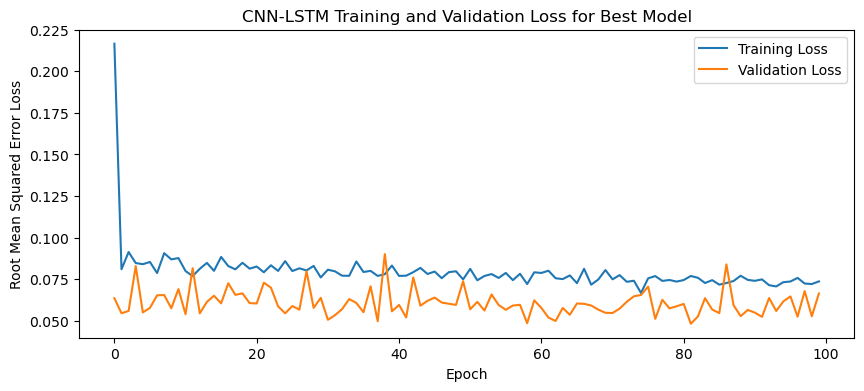

1/1 - 2s - loss: 0.0605 - 2s/epoch - 2s/step
Test Loss: 0.060531266033649445
Fold 2:
Epoch 1/100
19/19 [==============================] - 9s 163ms/step - loss: 0.1911 - val_loss: 0.0688
Epoch 2/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0823 - val_loss: 0.0560
Epoch 3/100
19/19 [==============================] - 1s 33ms/step - loss: 0.0817 - val_loss: 0.0717
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0845 - val_loss: 0.0849
Epoch 5/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0832 - val_loss: 0.0671
Epoch 6/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0800 - val_loss: 0.0571
Epoch 7/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0792 - val_loss: 0.0754
Epoch 8/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0856 - val_loss: 0.0589
Epoch 9/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0707 - val_loss: 0.0708
Epoch 10/100
1

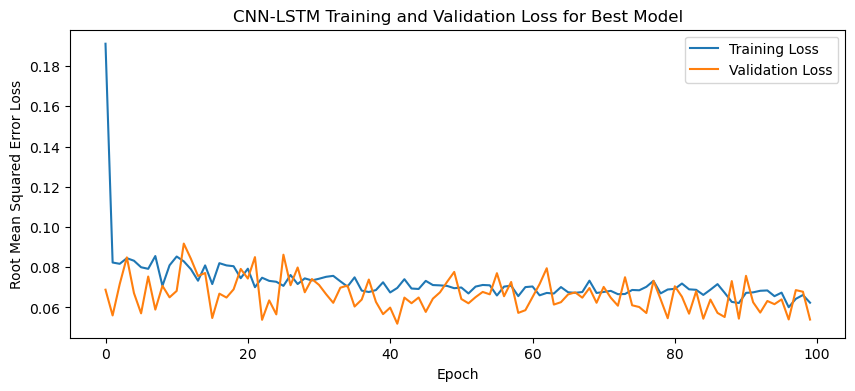

1/1 - 1s - loss: 0.1048 - 1s/epoch - 1s/step
Test Loss: 0.10484369844198227
Fold 3:
Epoch 1/100
19/19 [==============================] - 11s 175ms/step - loss: 0.2109 - val_loss: 0.0800
Epoch 2/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0842 - val_loss: 0.1157
Epoch 3/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0842 - val_loss: 0.0865
Epoch 4/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0864 - val_loss: 0.0685
Epoch 5/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0825 - val_loss: 0.0831
Epoch 6/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0747 - val_loss: 0.0682
Epoch 7/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0819 - val_loss: 0.0612
Epoch 8/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0843 - val_loss: 0.0948
Epoch 9/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0838 - val_loss: 0.0709
Epoch 10/100
1

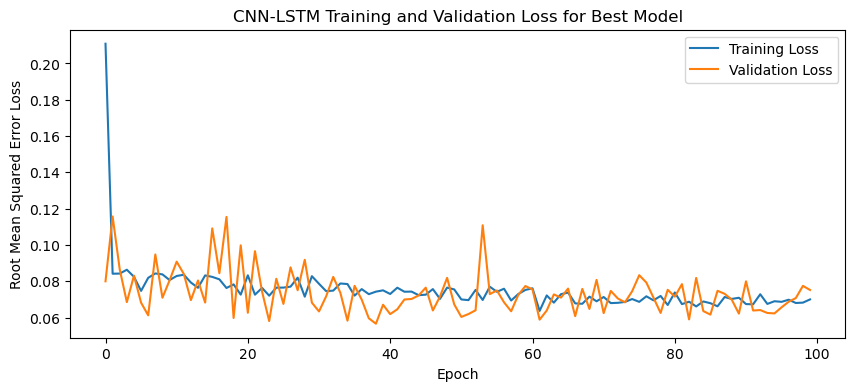

1/1 - 2s - loss: 0.0802 - 2s/epoch - 2s/step
Test Loss: 0.08018442988395691
Fold 4:
Epoch 1/100
20/20 [==============================] - 9s 149ms/step - loss: 0.3164 - val_loss: 0.0570
Epoch 2/100
20/20 [==============================] - 1s 35ms/step - loss: 0.1094 - val_loss: 0.0592
Epoch 3/100
20/20 [==============================] - 1s 26ms/step - loss: 0.1098 - val_loss: 0.0632
Epoch 4/100
20/20 [==============================] - 0s 17ms/step - loss: 0.1107 - val_loss: 0.0892
Epoch 5/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1131 - val_loss: 0.1038
Epoch 6/100
20/20 [==============================] - 0s 22ms/step - loss: 0.1106 - val_loss: 0.0794
Epoch 7/100
20/20 [==============================] - 0s 23ms/step - loss: 0.1033 - val_loss: 0.0983
Epoch 8/100
20/20 [==============================] - 0s 23ms/step - loss: 0.1091 - val_loss: 0.0558
Epoch 9/100
20/20 [==============================] - 0s 21ms/step - loss: 0.1188 - val_loss: 0.0678
Epoch 10/100
20

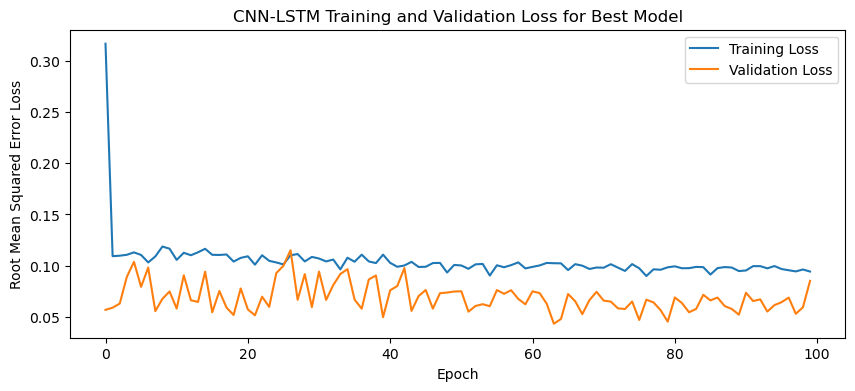

1/1 - 2s - loss: 0.0790 - 2s/epoch - 2s/step
Test Loss: 0.07903682440519333
Fold 5:
Epoch 1/100
19/19 [==============================] - 13s 230ms/step - loss: 0.2159 - val_loss: 0.0775
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0832 - val_loss: 0.1081
Epoch 3/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0900 - val_loss: 0.1102
Epoch 4/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0862 - val_loss: 0.0716
Epoch 5/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0805 - val_loss: 0.0738
Epoch 6/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0854 - val_loss: 0.0896
Epoch 7/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0769 - val_loss: 0.0890
Epoch 8/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0795 - val_loss: 0.0893
Epoch 9/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0839 - val_loss: 0.0757
Epoch 10/100
1

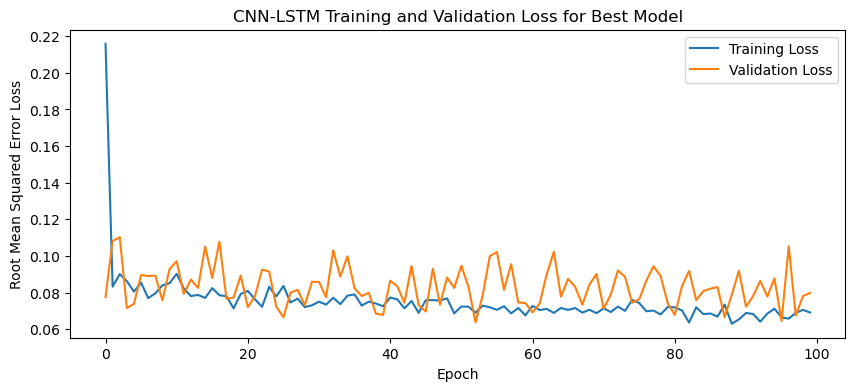

1/1 - 2s - loss: 0.0604 - 2s/epoch - 2s/step
Test Loss: 0.06044254079461098


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

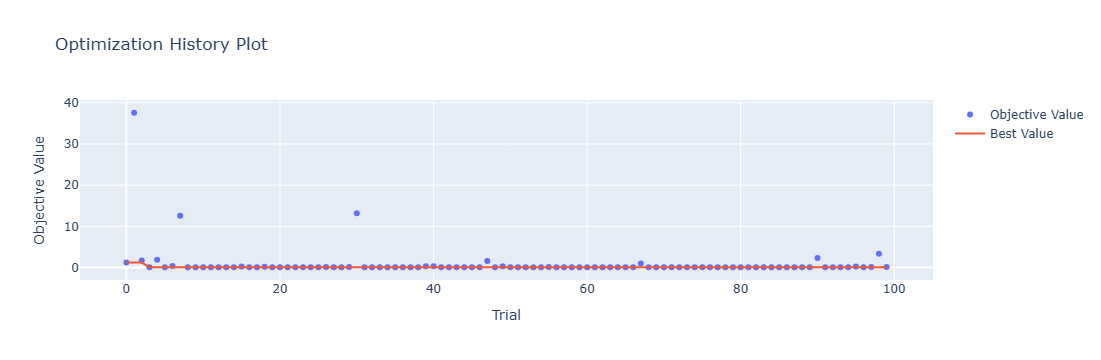

In [5]:
optuna.visualization.plot_optimization_history(study)

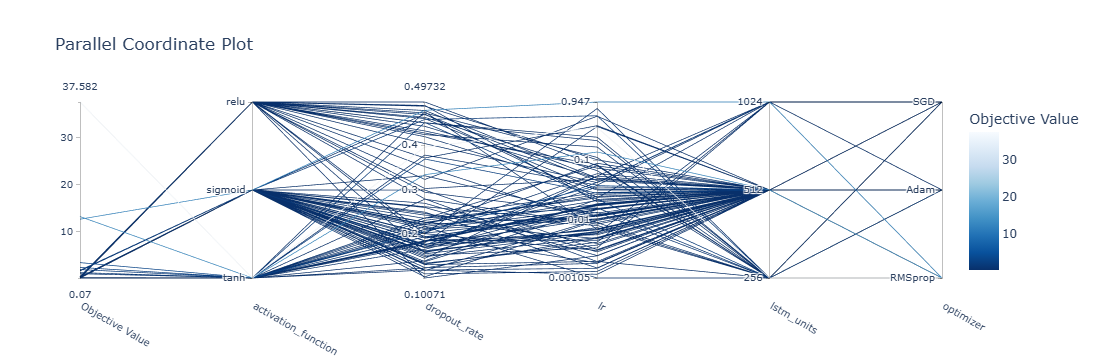

In [6]:
optuna.visualization.plot_parallel_coordinate(study)

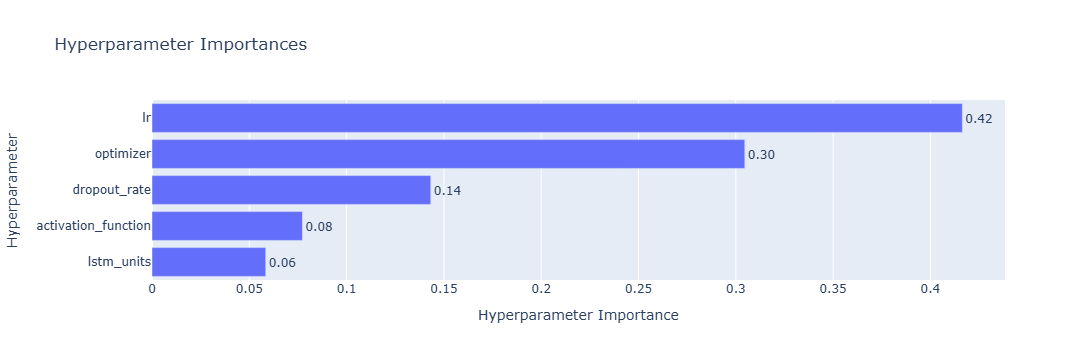

In [7]:
optuna.visualization.plot_param_importances(study)

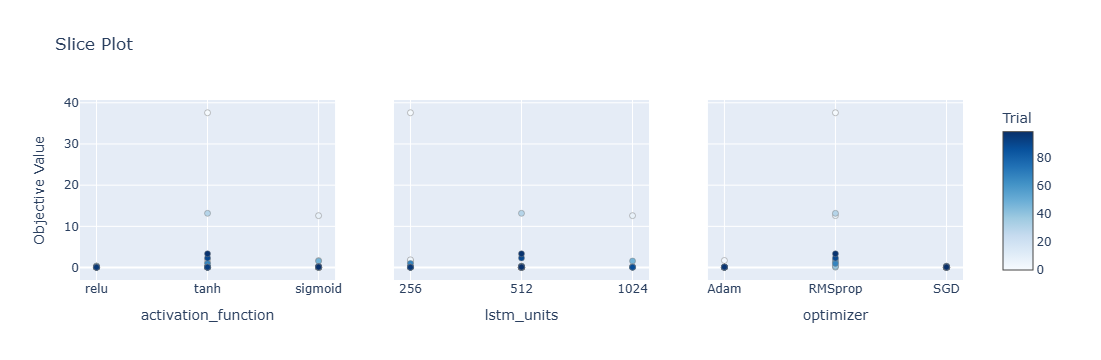

In [8]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

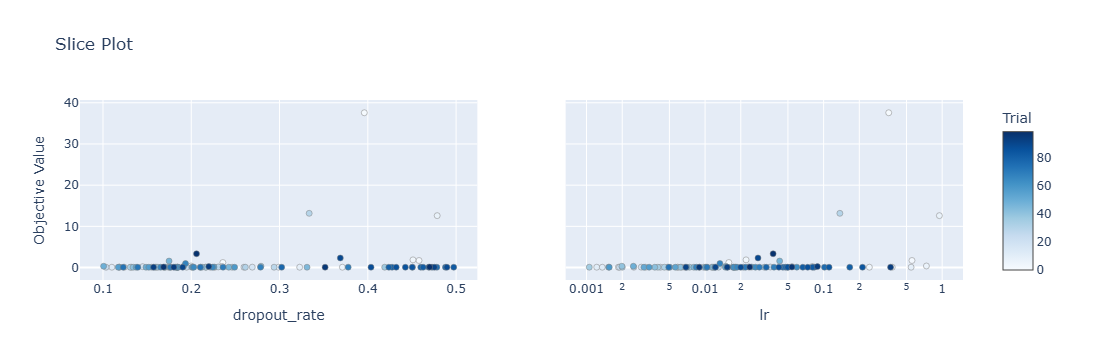

In [9]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 6s 79ms/step - loss: 0.1938 - accuracy: 0.0000e+00 - mae: 0.1782 - rmse: 0.1938 - mape: 43.3933 - pearson: 0.2533 - val_loss: 0.0964 - val_accuracy: 0.3333 - val_mae: 0.0792 - val_rmse: 0.0964 - val_mape: 19.8021 - val_pearson: 0.3310
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.0911 - accuracy: 0.1579 - mae: 0.0759 - rmse: 0.0911 - mape: 19.5591 - pearson: 0.3844 - val_loss: 0.0644 - val_accuracy: 0.3333 - val_mae: 0.0558 - val_rmse: 0.0644 - val_mape: 13.0746 - val_pearson: 0.2374
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0911 - accura

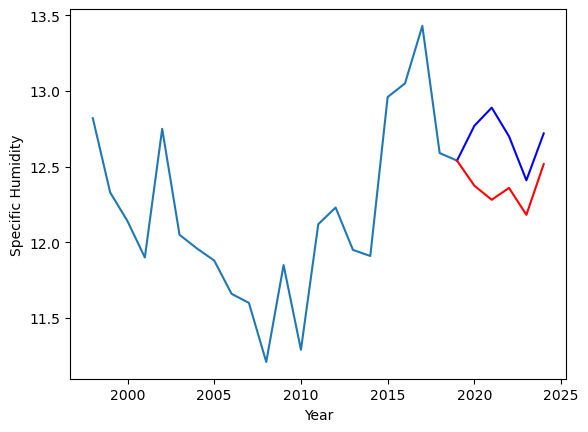

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.63		-0.25
10.09		9.53		-0.56
9.65		9.60		-0.05
9.13		9.43		0.30
9.32		9.74		0.42


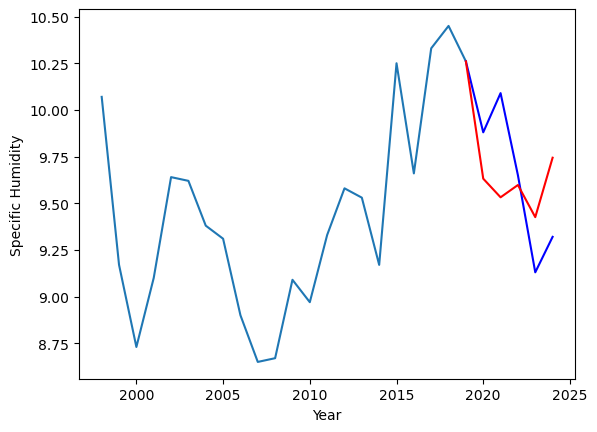

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.374623
1                1    9.88   9.631705


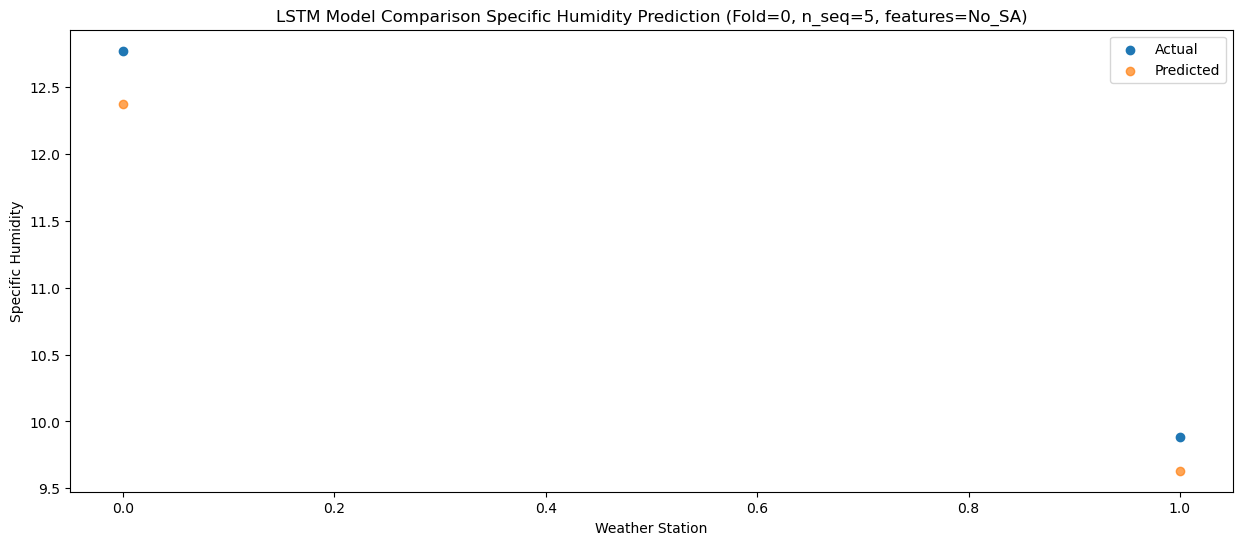

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.281321
1                1   10.09   9.531864


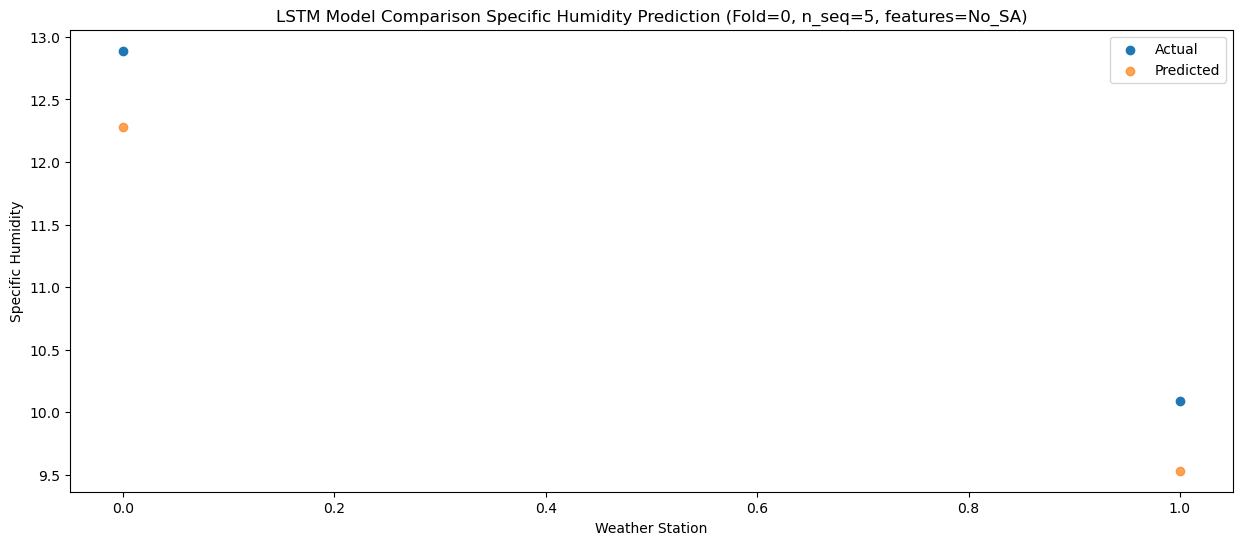

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.359688
1                1    9.65   9.597765


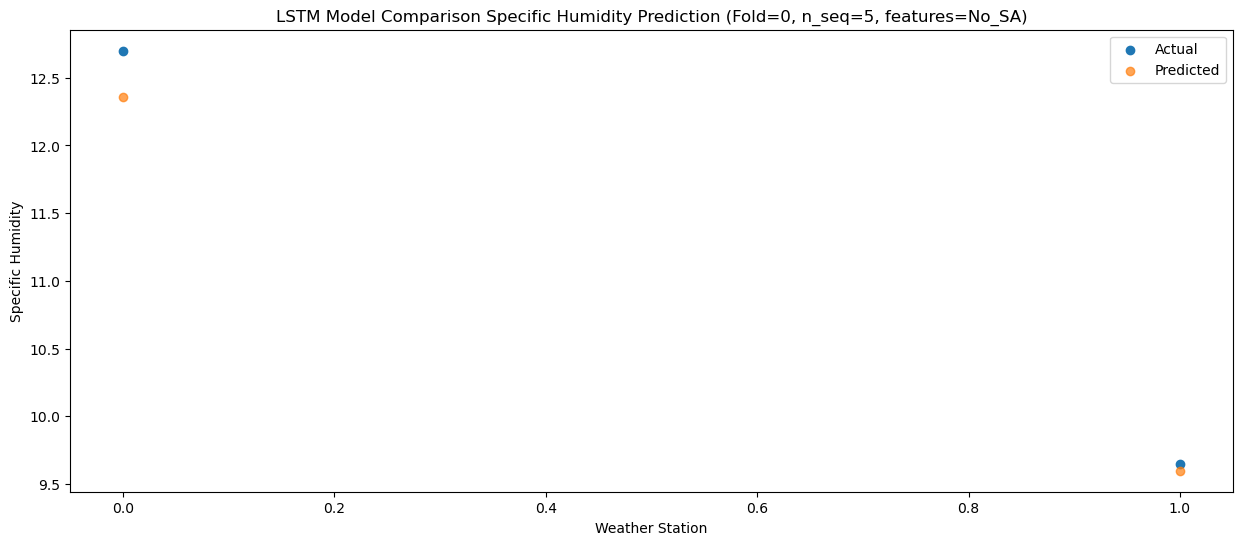

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  12.181960
1                1    9.13   9.425575


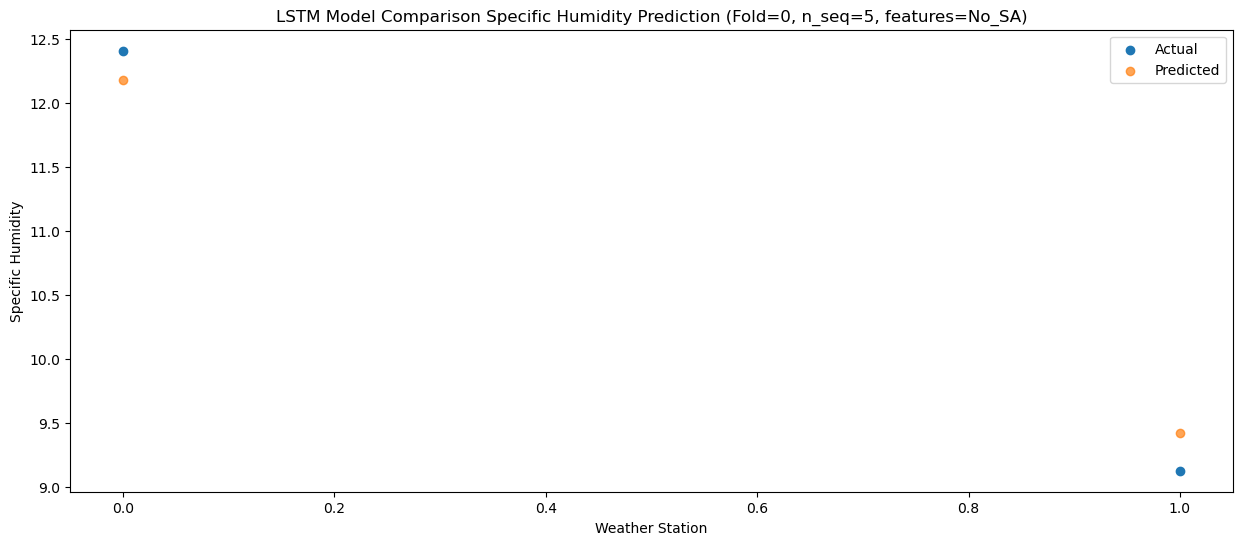

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72  12.516884
1                1    9.32   9.743981


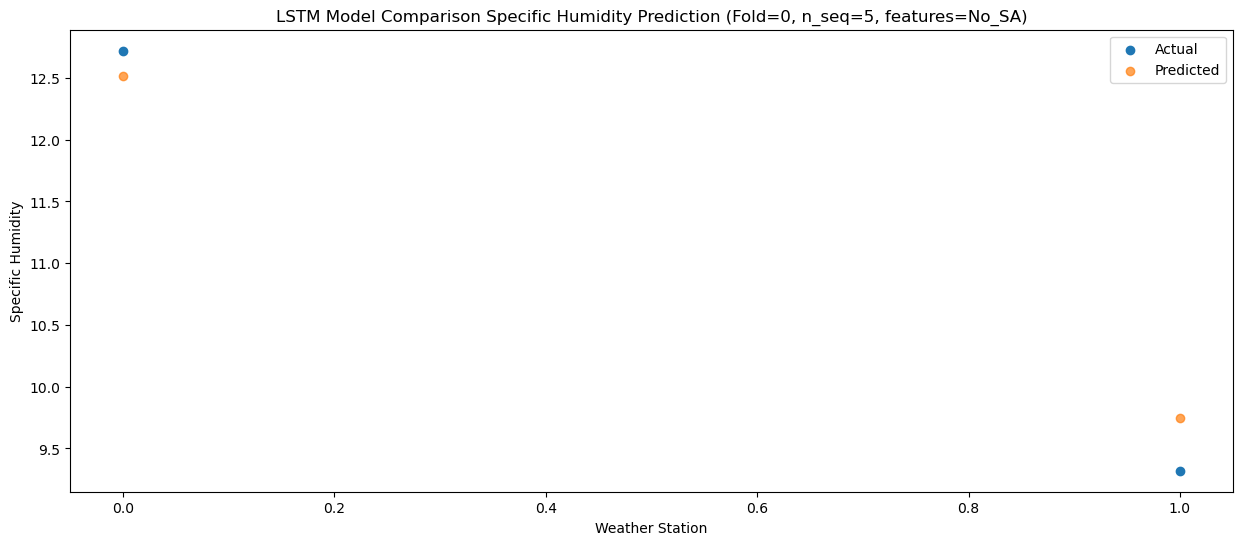

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.37462307  9.63170508]
 [12.28132106  9.5318638 ]
 [12.3596885   9.59776474]
 [12.18196035  9.42557455]
 [12.51688395  9.74398116]]
Year at t+1:
t+1 SKRMSE: 0.330131
t+1 KRMSE: 0.330131
t+1 MAE: 0.321836
t+1 SKMAPE: 0.028046
t+1 R2_SCORE: 0.947804
t+1 KMAPE: 0.028046
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.583955
t+2 KRMSE: 0.583955
t+2 MAE: 0.583408
t+2 SKMAPE: 0.051268
t+2 R2_SCORE: 0.826019
t+2 KMAPE: 0.051268
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.243455
t+3 KRMSE: 0.243455
t+3 MAE: 0.196273
t+3 SKMAPE: 0.016105
t+3 R2_SCORE: 0.974514
t+3 KMAPE: 0.016105
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.263976
t+4 KRMSE: 0.263976
t+4 MAE: 0.261807
t+4 SKMAPE: 0.025375
t+4 R2_SCORE: 0.974092
t+4 KMAPE: 0.025375
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.332

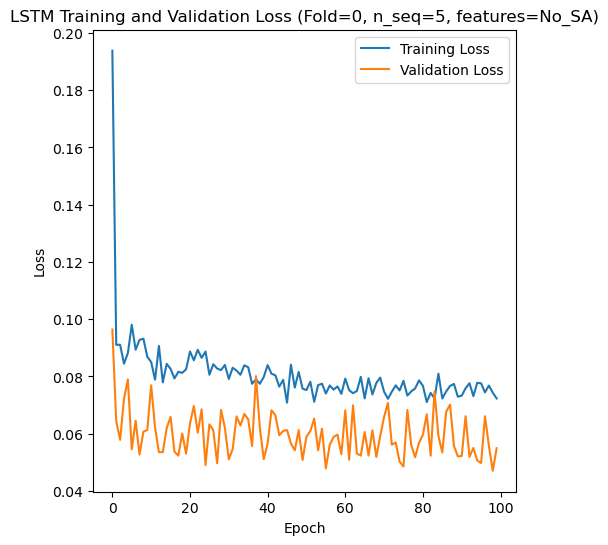

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 5s 105ms/step - loss: 0.1977 - accuracy: 0.2632 - mae: 0.1871 - rmse: 0.1977 - mape: 43.4556 - pearson: 0.3298 - val_loss: 0.0726 - val_accuracy: 0.3333 - val_mae: 0.0617 - val_rmse: 0.0726 - val_mape: 14.6334 - val_pearson: 0.3826
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0798 - accuracy: 0.3684 - mae: 0.0680 - rmse: 0.0798 - mape: 16.6718 - pearson: 0.3405 - val_loss: 0.0883 - val_accuracy: 0.3333 - val_mae: 0.0759 - val_rmse: 0.0883 - val_mape: 19.1648 - val_pearson: 0.1297
Epoch 3/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0883 - accuracy:

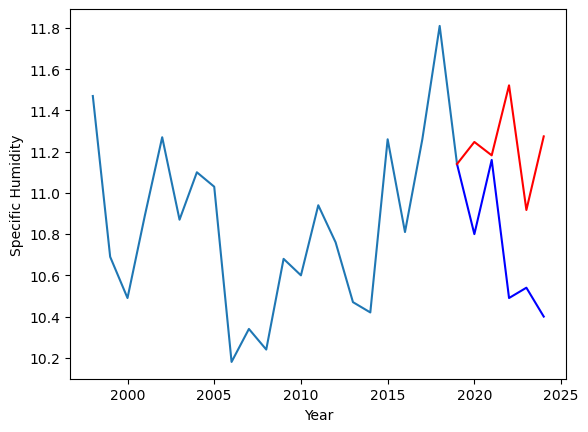

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		7.45		-0.21
6.92		7.39		0.47
7.36		7.74		0.38
6.79		7.13		0.34
6.94		7.50		0.56


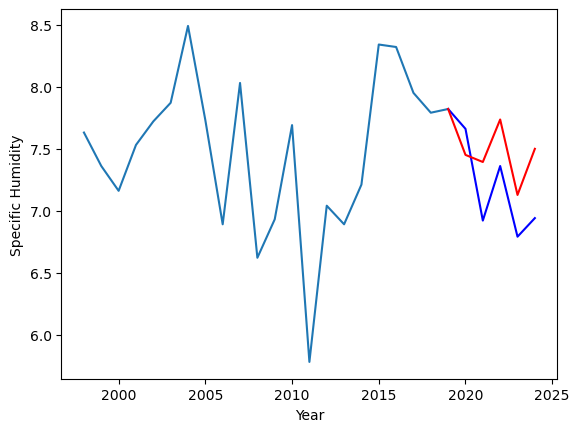

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.247057
1                1    7.66   7.449795


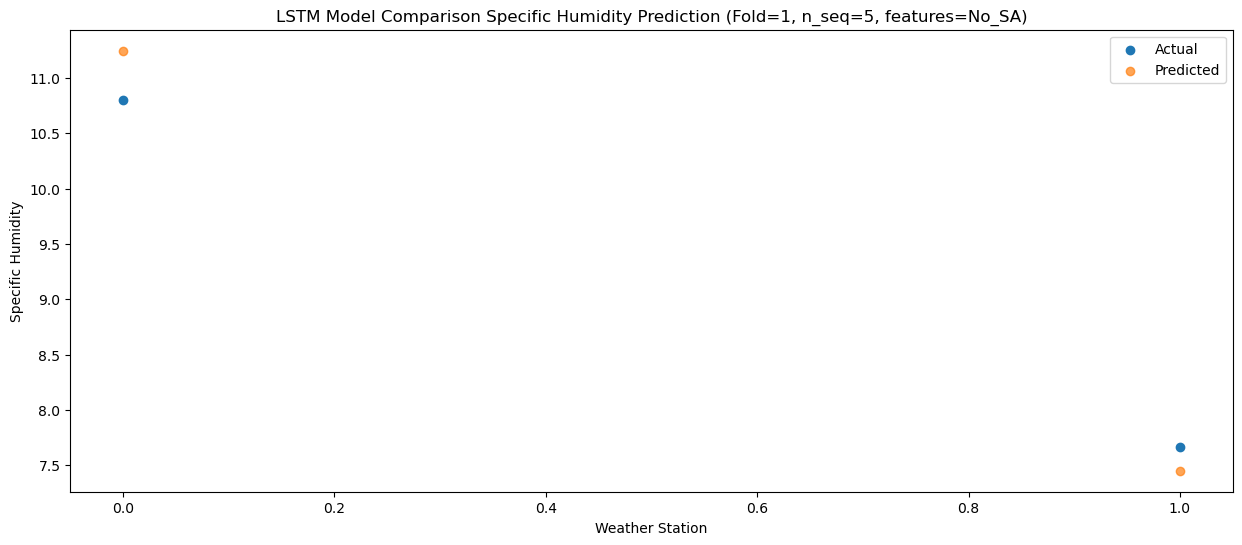

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  11.182178
1                1    6.92   7.392557


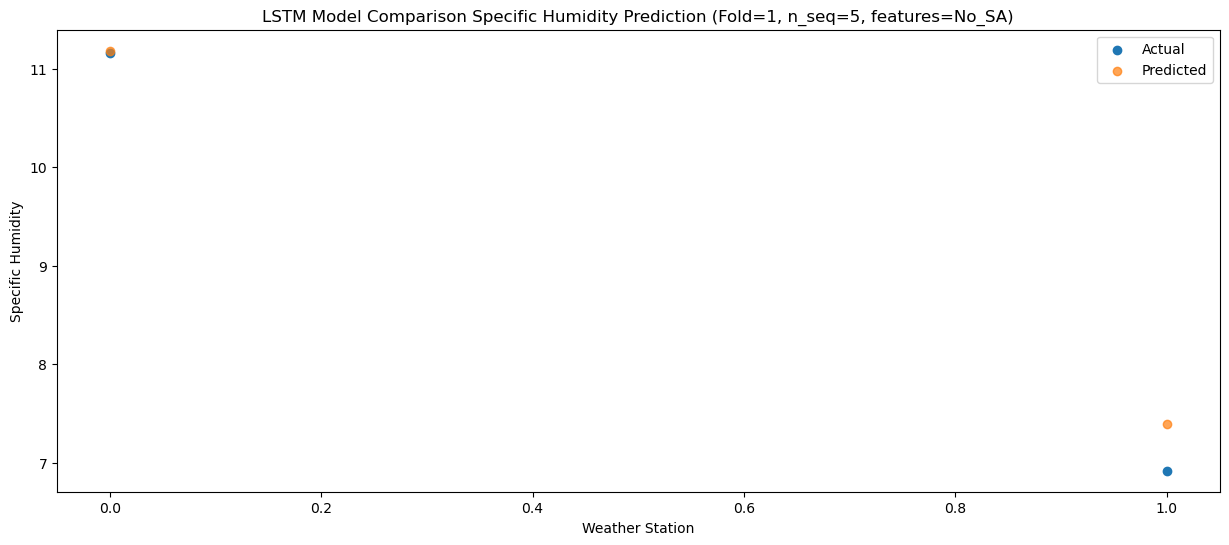

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  11.521783
1                1    7.36   7.735243


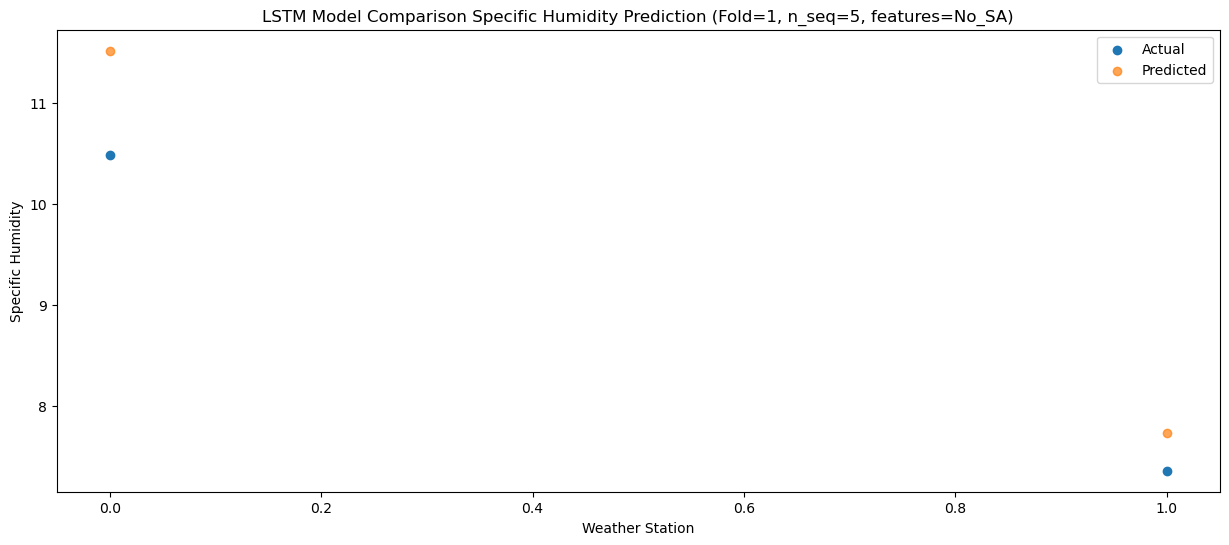

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.916964
1                1    6.79   7.126723


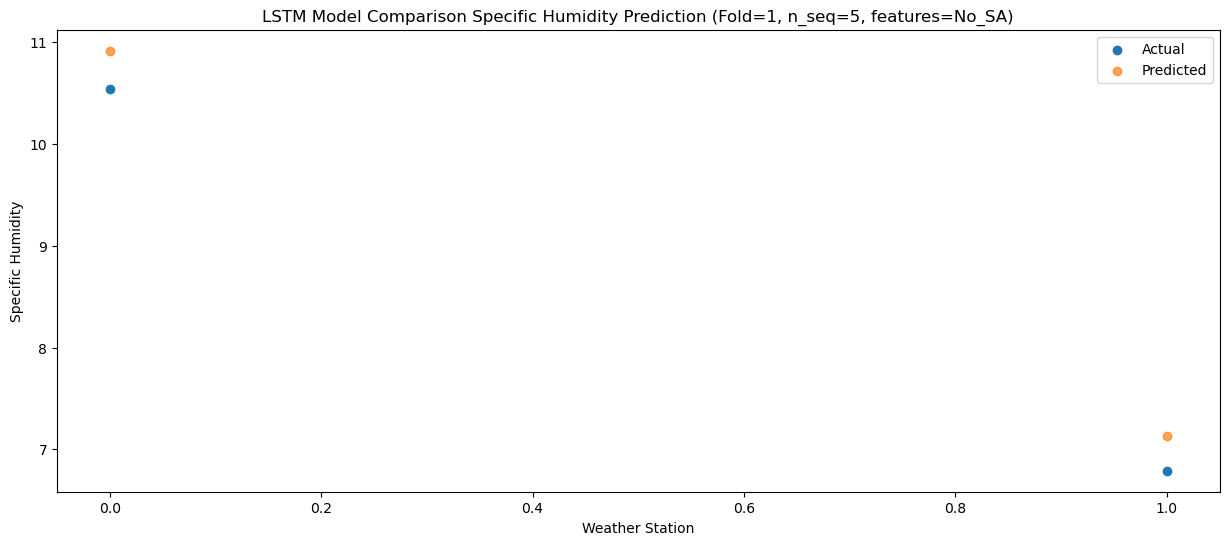

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  11.274181
1                1    6.94   7.498766


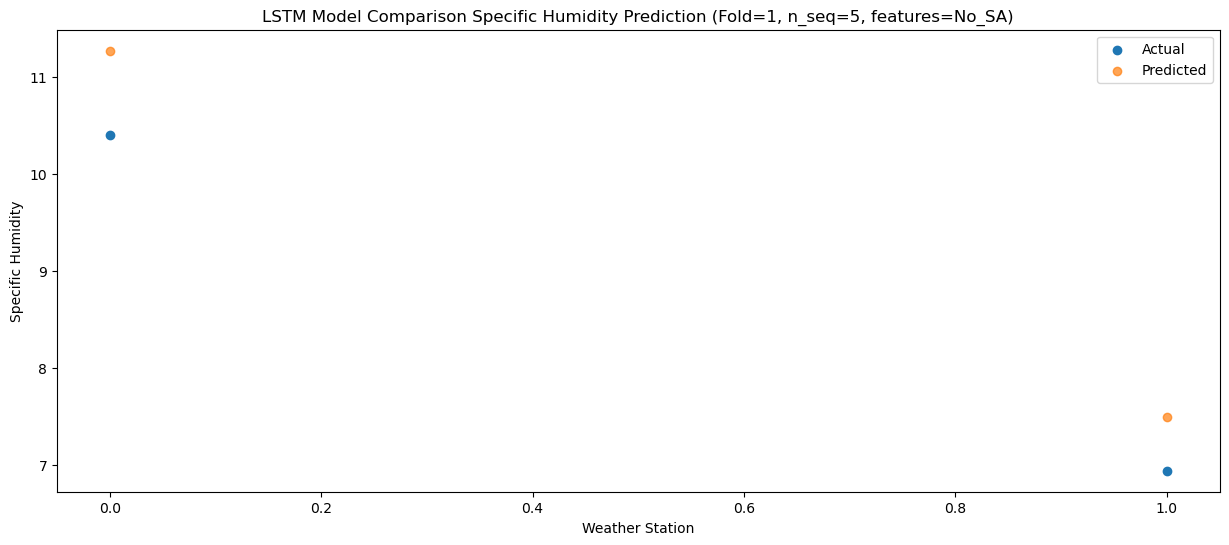

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[11.24705671  7.44979512]
 [11.18217802  7.39255684]
 [11.52178344  7.73524338]
 [10.91696438  7.12672299]
 [11.2741805   7.49876579]]
Year at t+1:
t+1 SKRMSE: 0.349318
t+1 KRMSE: 0.349318
t+1 MAE: 0.328631
t+1 SKMAPE: 0.034418
t+1 R2_SCORE: 0.950496
t+1 KMAPE: 0.034418
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.334516
t+2 KRMSE: 0.334516
t+2 MAE: 0.247367
t+2 SKMAPE: 0.035138
t+2 R2_SCORE: 0.975102
t+2 KMAPE: 0.035138
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.776333
t+3 KRMSE: 0.776333
t+3 MAE: 0.703513
t+3 SKMAPE: 0.074671
t+3 R2_SCORE: 0.753925
t+3 KMAPE: 0.074671
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.357410
t+4 KRMSE: 0.357410
t+4 MAE: 0.356844
t+4 SKMAPE: 0.042678
t+4 R2_SCORE: 0.963664
t+4 KMAPE: 0.042678
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.733625


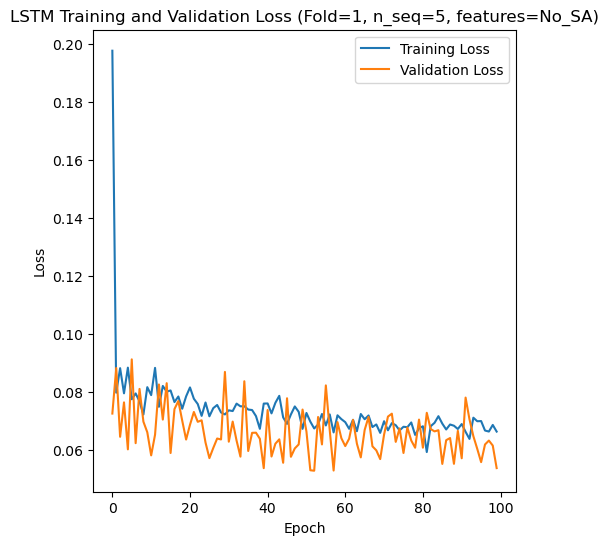

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 5s 71ms/step - loss: 0.2149 - accuracy: 0.3684 - mae: 0.2018 - rmse: 0.2149 - mape: 46.6391 - pearson: 0.2507 - val_loss: 0.0957 - val_accuracy: 0.3333 - val_mae: 0.0733 - val_rmse: 0.0957 - val_mape: 18.4261 - val_pearson: 0.1079
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0772 - accuracy: 0.2105 - mae: 0.0665 - rmse: 0.0772 - mape: 16.5420 - pearson: 0.3096 - val_loss: 0.1159 - val_accuracy: 0.0000e+00 - val_mae: 0.0951 - val_rmse: 0.1159 - val_mape: 22.1242 - val_pearson: 0.1134
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0898 - accura

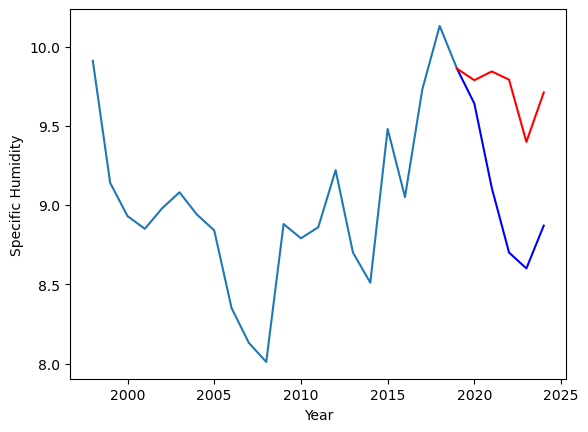

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		8.36		0.52
7.66		8.40		0.74
7.73		8.38		0.65
8.00		7.98		-0.02
8.01		8.29		0.28


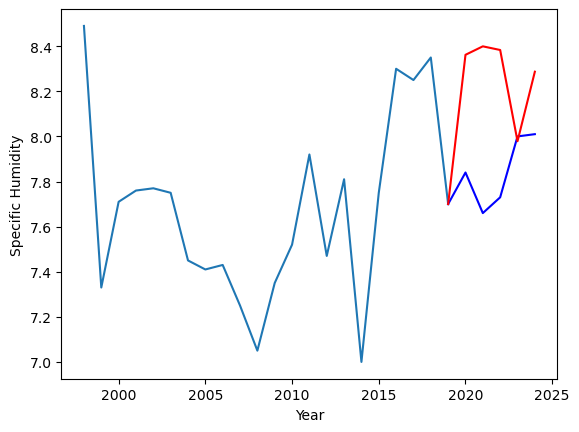

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.787477
1                1    7.84   8.361886


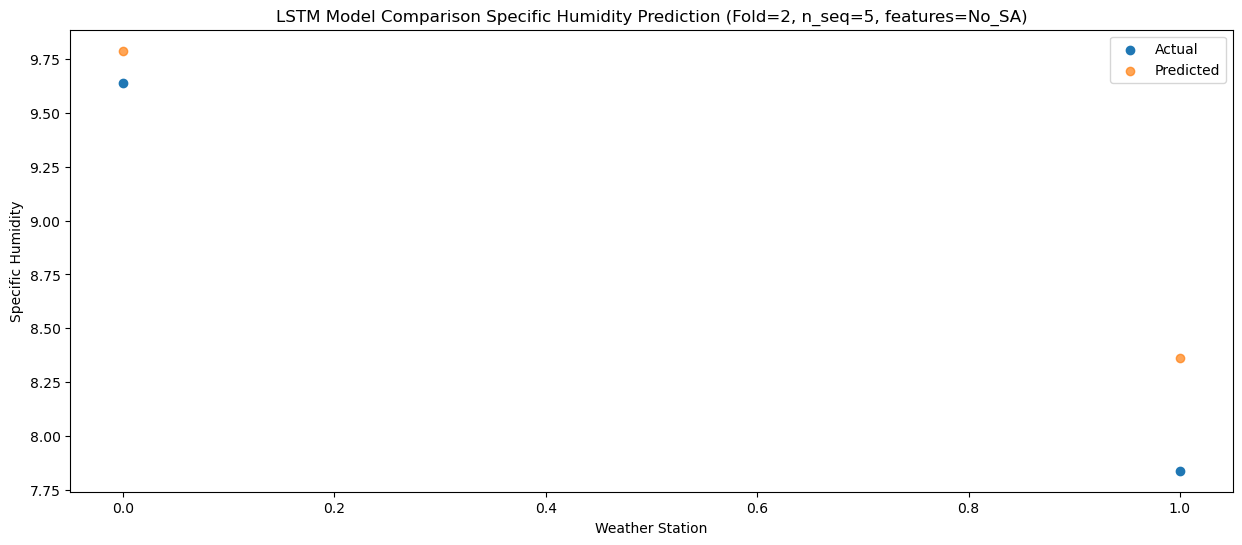

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.842804
1                1    7.66   8.399479


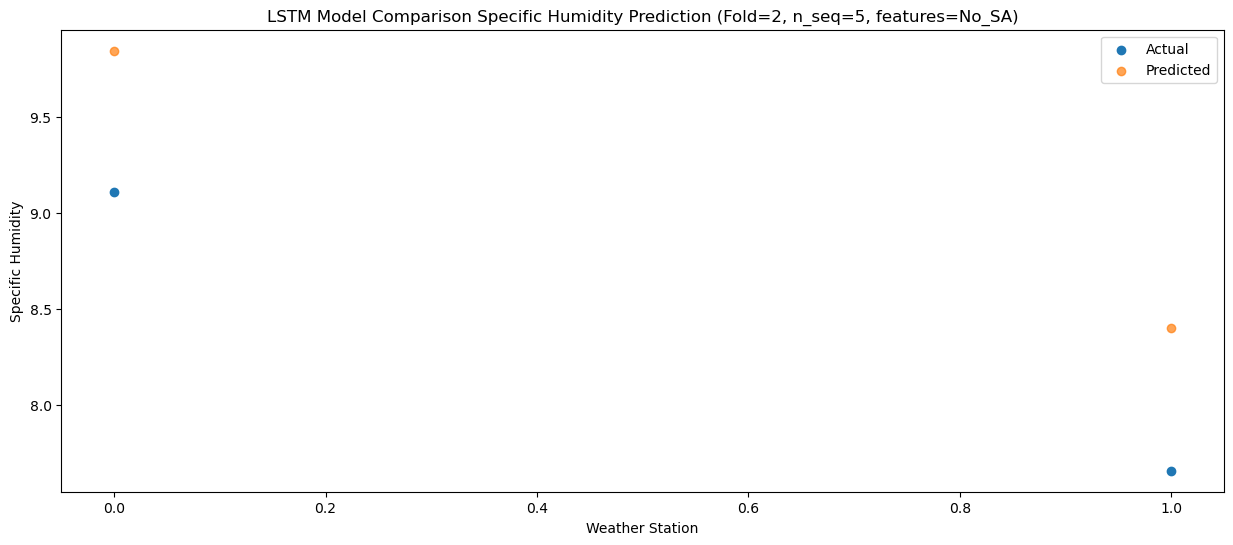

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.790975
1                1    7.73   8.383233


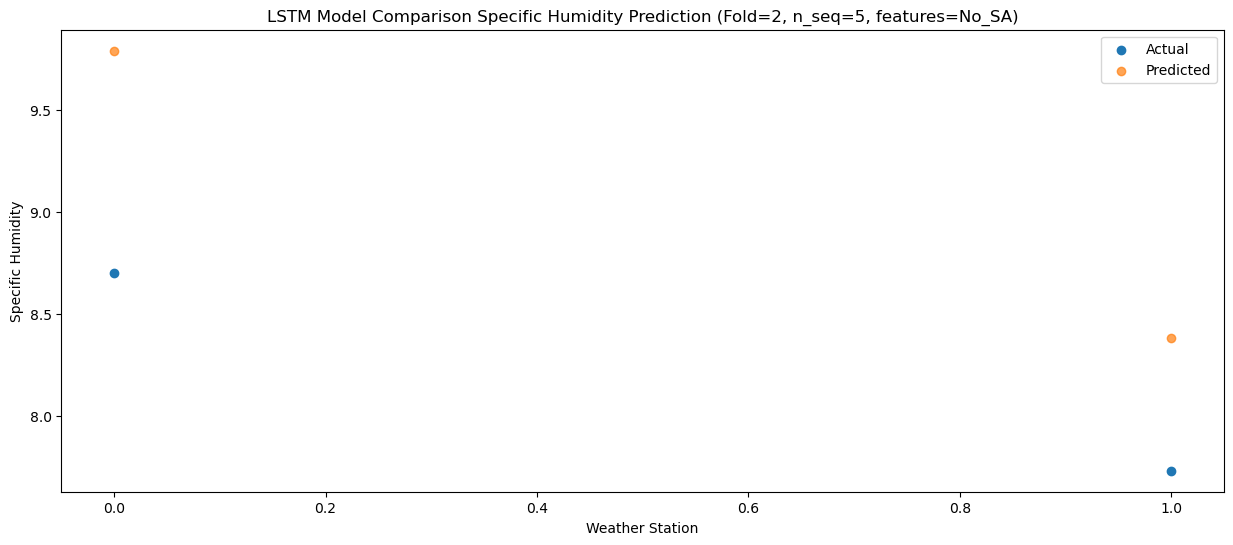

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.398052
1                1     8.0   7.978694


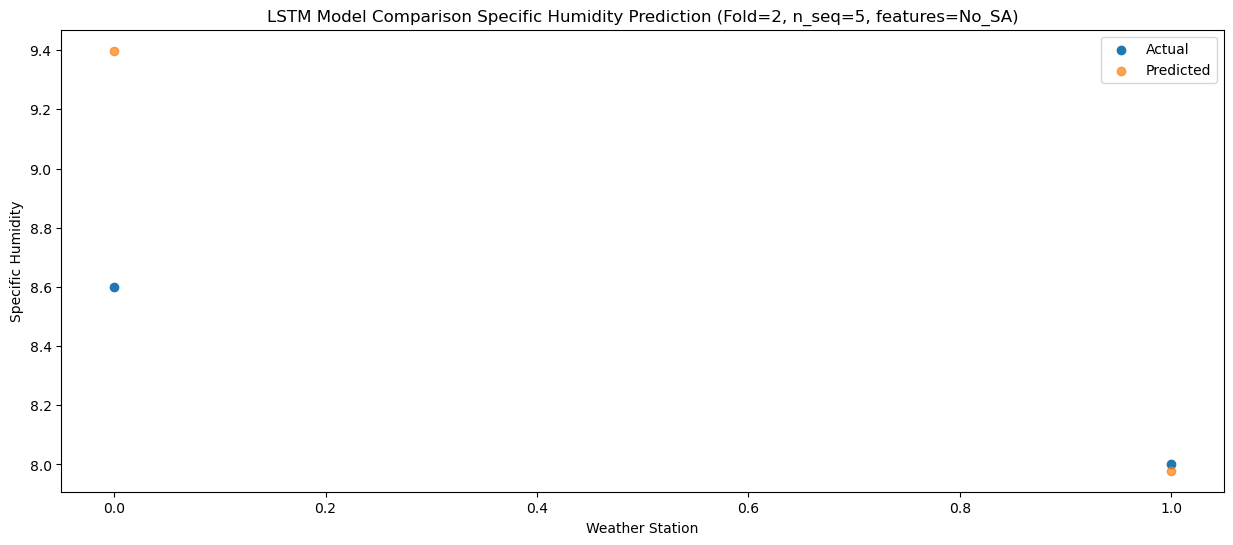

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87   9.709926
1                1    8.01   8.286979


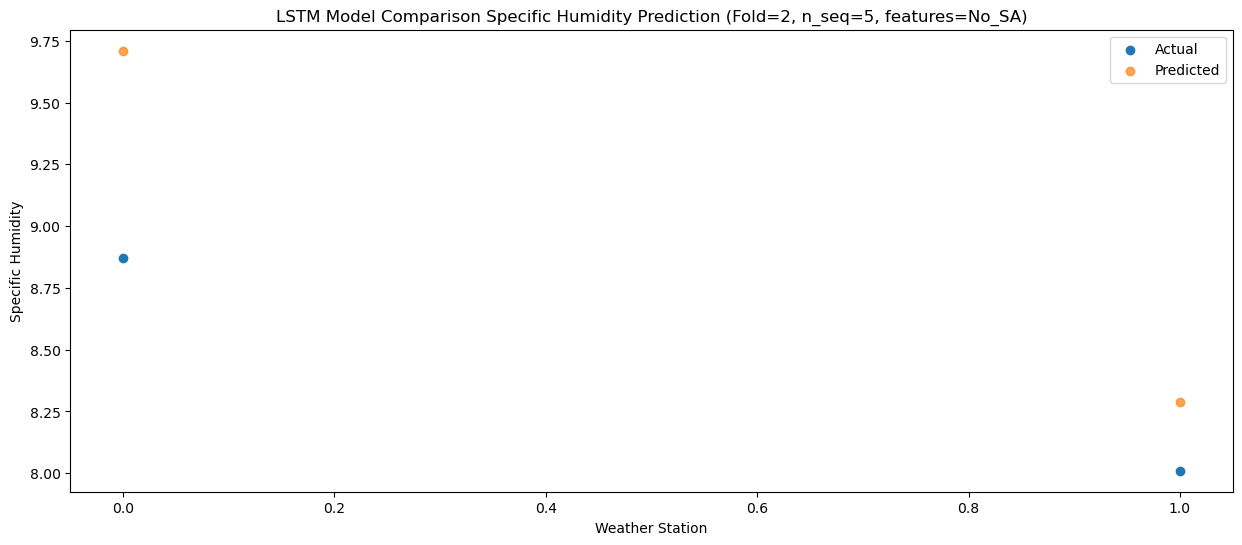

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.78747674 8.3618863 ]
 [9.84280365 8.39947926]
 [9.7909747  8.3832331 ]
 [9.3980523  7.97869399]
 [9.70992604 8.28697854]]
Year at t+1:
t+1 SKRMSE: 0.383481
t+1 KRMSE: 0.383481
t+1 MAE: 0.334682
t+1 SKMAPE: 0.040933
t+1 R2_SCORE: 0.818448
t+1 KMAPE: 0.040933
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.736149
t+2 KRMSE: 0.736149
t+2 MAE: 0.736141
t+2 SKMAPE: 0.088489
t+2 R2_SCORE: -0.030992
t+2 KMAPE: 0.088489
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 0.899149
t+3 KRMSE: 0.899149
t+3 MAE: 0.872104
t+3 SKMAPE: 0.104953
t+3 R2_SCORE: -2.437006
t+3 KMAPE: 0.104953
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.564509
t+4 KRMSE: 0.564509
t+4 MAE: 0.409679
t+4 SKMAPE: 0.047730
t+4 R2_SCORE: -2.540786
t+4 KMAPE: 0.047730
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.625377
t+5 KRMSE: 0.6253

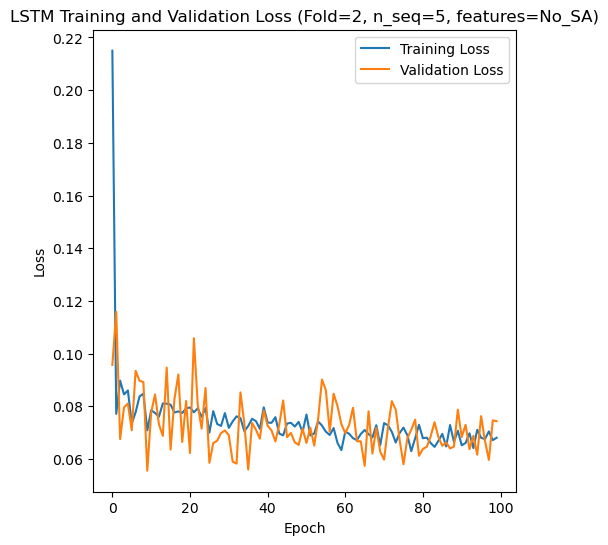

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 6s 71ms/step - loss: 0.2973 - accuracy: 0.1500 - mae: 0.2792 - rmse: 0.2973 - mape: 47.2339 - pearson: 0.2722 - val_loss: 0.1064 - val_accuracy: 0.0000e+00 - val_mae: 0.0918 - val_rmse: 0.1064 - val_mape: 14.3146 - val_pearson: 0.3396
Epoch 2/100
20/20 [==============================] - 0s 11ms/step - loss: 0.1133 - accuracy: 0.4000 - mae: 0.0987 - rmse: 0.1133 - mape: 18.2392 - pearson: 0.3413 - val_loss: 0.0651 - val_accuracy: 0.0000e+00 - val_mae: 0.0526 - val_rmse: 0.0651 - val_mape: 8.7159 - val_pearson: 0.7169
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.1158 - accuracy: 0.2500 - mae: 0.0987 - rmse: 0.1158 - mape: 17.7611

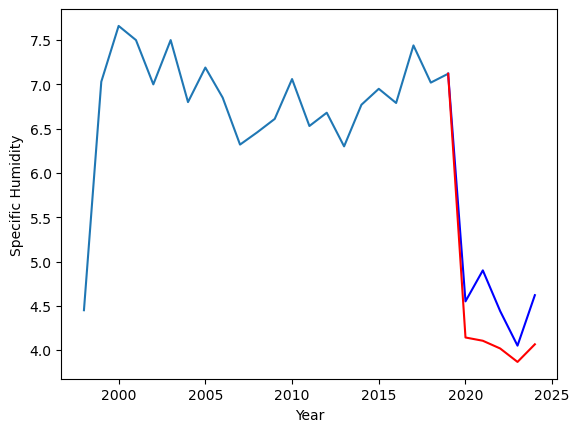

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		8.01		-0.20
8.12		7.95		-0.17
8.09		7.88		-0.21
7.62		7.72		0.10
7.64		7.91		0.27


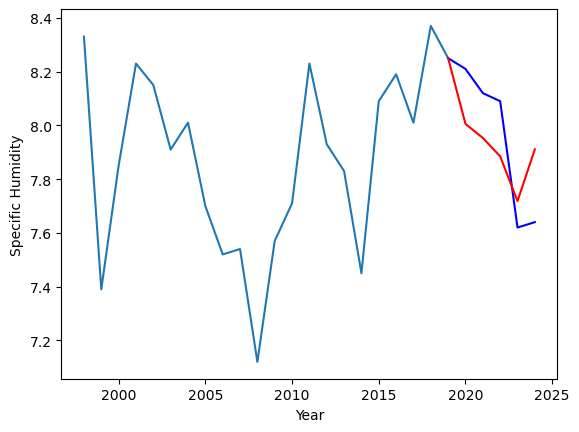

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.142167
1                1    8.21   8.005391


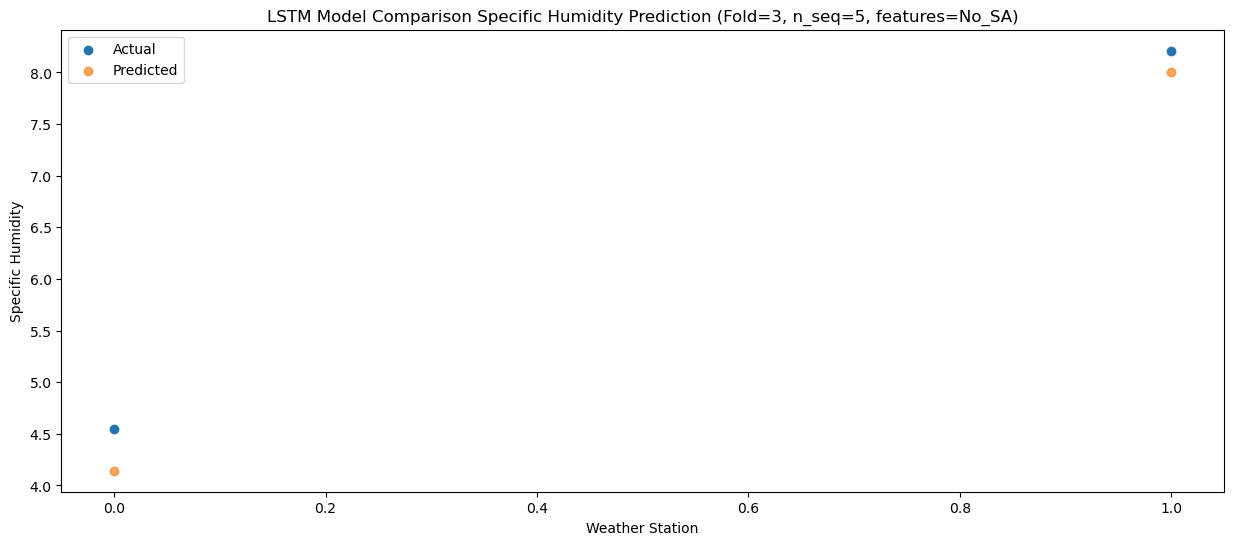

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   4.105263
1                1    8.12   7.953316


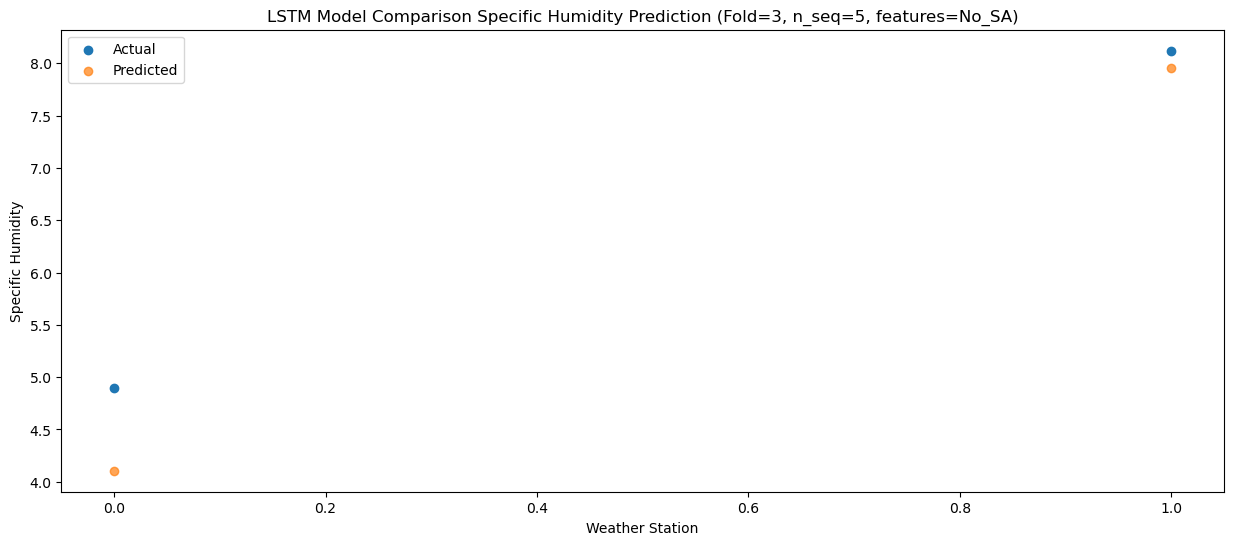

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   4.018006
1                1    8.09   7.884861


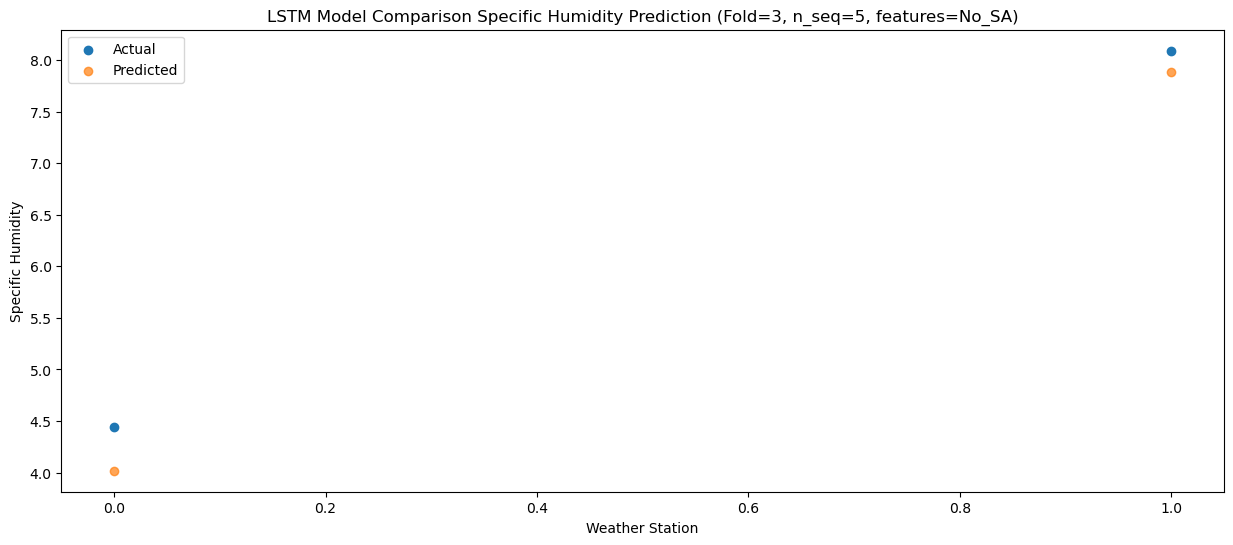

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05   3.866258
1                1    7.62   7.718378


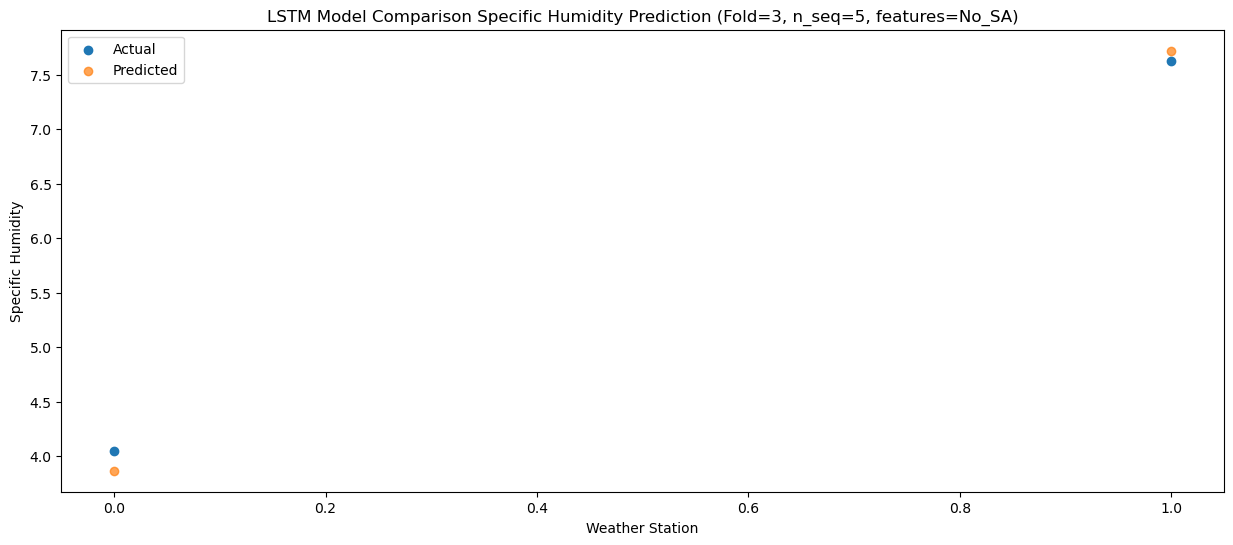

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62   4.065225
1                1    7.64   7.911205


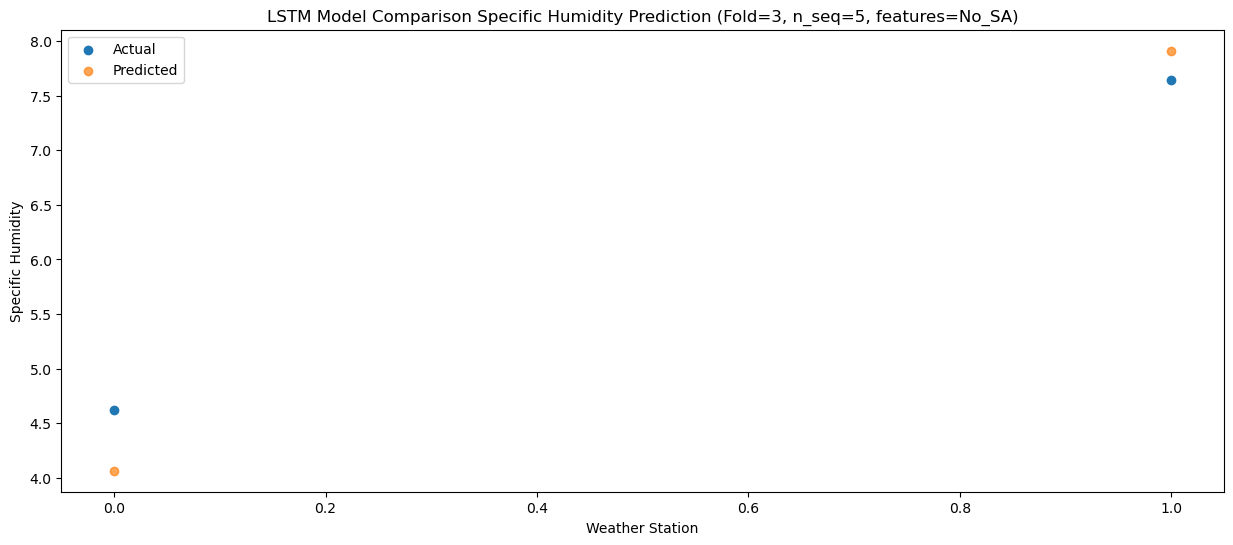

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.14216704 8.00539093]
 [4.10526254 7.95331638]
 [4.01800578 7.8848613 ]
 [3.8662583  7.71837793]
 [4.06522512 7.91120529]]
Year at t+1:
t+1 SKRMSE: 0.322640
t+1 KRMSE: 0.322640
t+1 MAE: 0.306221
t+1 SKMAPE: 0.057278
t+1 R2_SCORE: 0.968916
t+1 KMAPE: 0.057278
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.574191
t+2 KRMSE: 0.574191
t+2 MAE: 0.480711
t+2 SKMAPE: 0.091359
t+2 R2_SCORE: 0.872808
t+2 KMAPE: 0.091359
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.331784
t+3 KRMSE: 0.331784
t+3 MAE: 0.313566
t+3 SKMAPE: 0.060200
t+3 R2_SCORE: 0.966949
t+3 KMAPE: 0.060200
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.147376
t+4 KRMSE: 0.147376
t+4 MAE: 0.141060
t+4 SKMAPE: 0.029139
t+4 R2_SCORE: 0.993183
t+4 KMAPE: 0.029139
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.436651
t+5 KRMSE: 0.436651


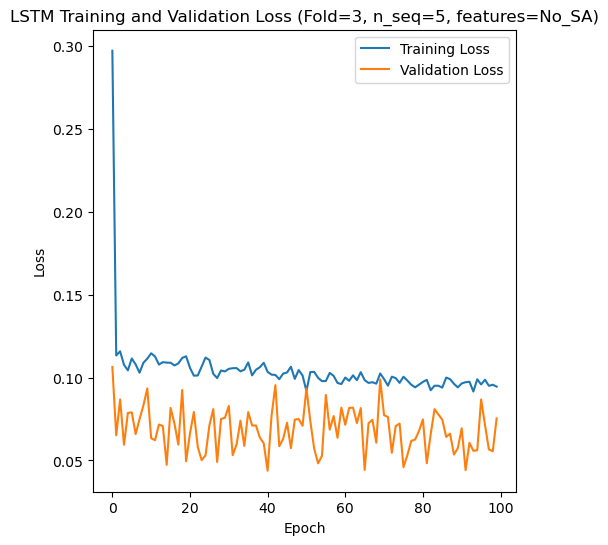

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 6s 107ms/step - loss: 0.2062 - accuracy: 0.3158 - mae: 0.1940 - rmse: 0.2062 - mape: 45.5394 - pearson: 0.2882 - val_loss: 0.0811 - val_accuracy: 0.0000e+00 - val_mae: 0.0647 - val_rmse: 0.0811 - val_mape: 16.0159 - val_pearson: 0.1427
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0853 - accuracy: 0.3684 - mae: 0.0694 - rmse: 0.0853 - mape: 17.4125 - pearson: 0.4037 - val_loss: 0.0688 - val_accuracy: 0.0000e+00 - val_mae: 0.0553 - val_rmse: 0.0688 - val_mape: 13.5522 - val_pearson: 0.2035
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0773 - ac

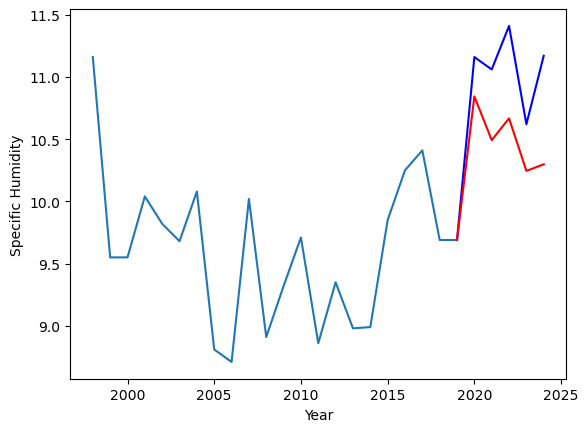

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		7.99		0.20
7.52		7.65		0.13
7.85		7.86		0.01
7.25		7.43		0.18
7.48		7.48		0.00


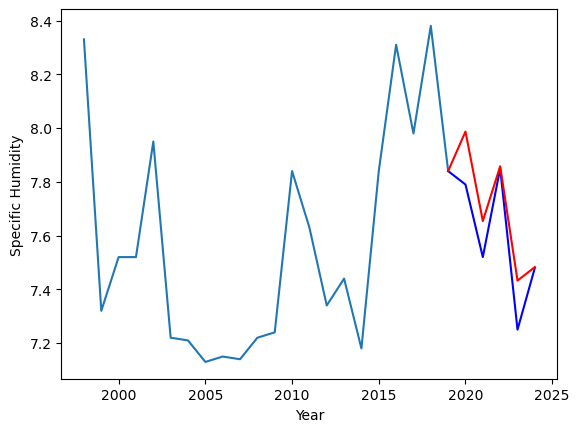

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.843556
1                1    7.79   7.987052


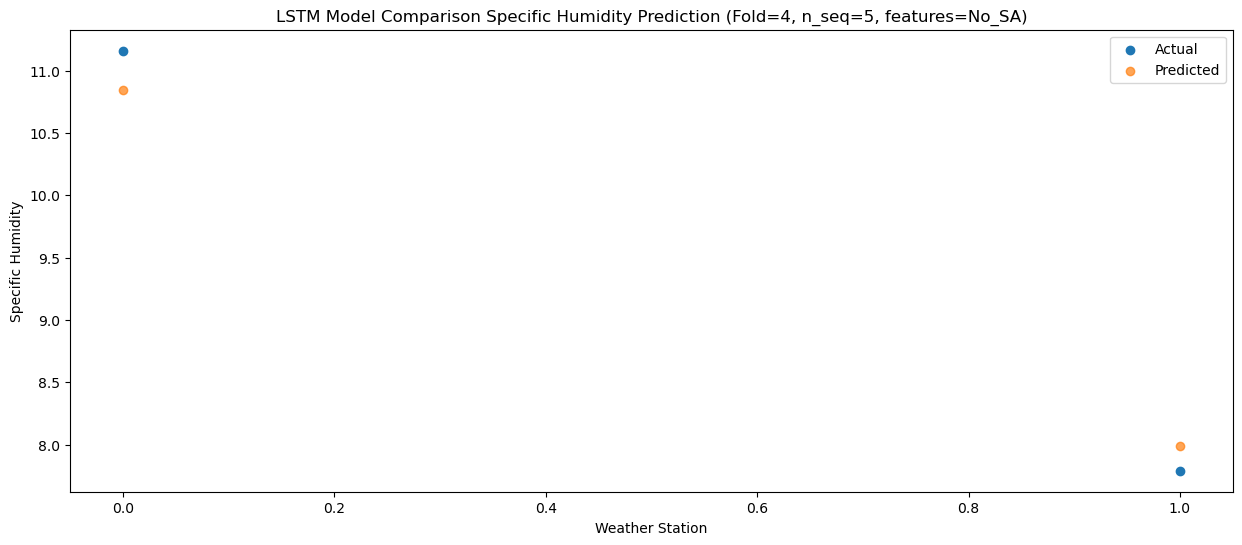

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  10.492255
1                1    7.52   7.654050


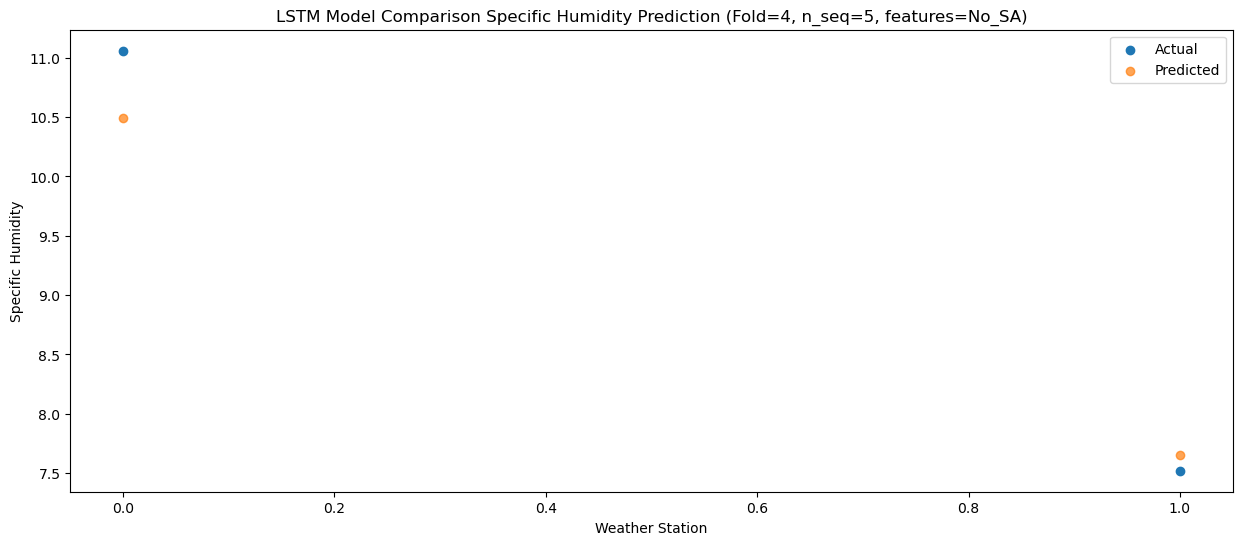

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  10.667143
1                1    7.85   7.857823


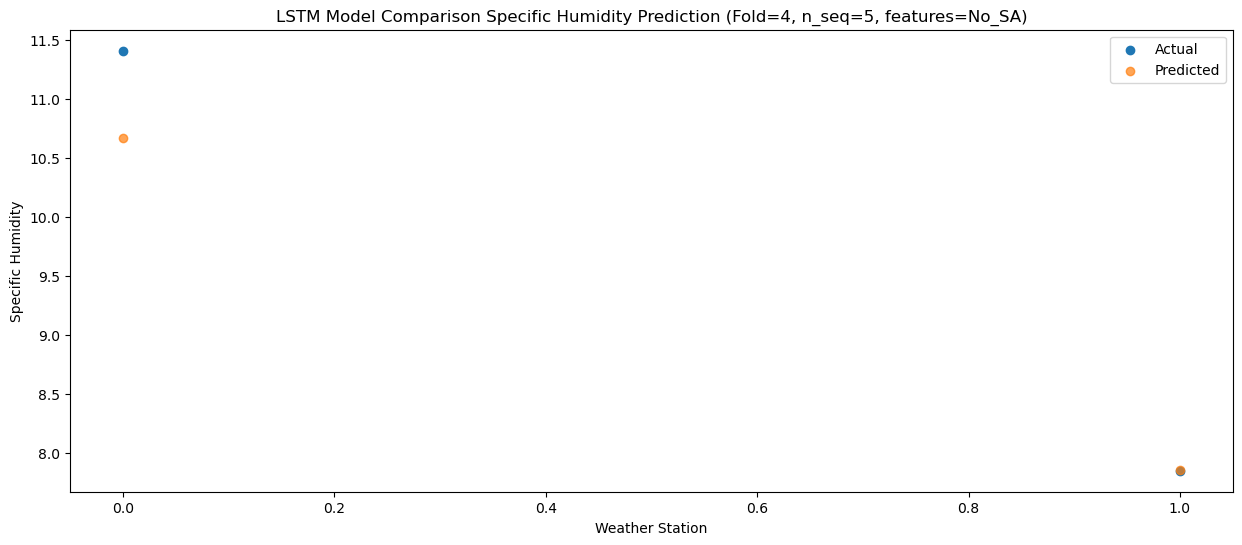

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.245196
1                1    7.25   7.432509


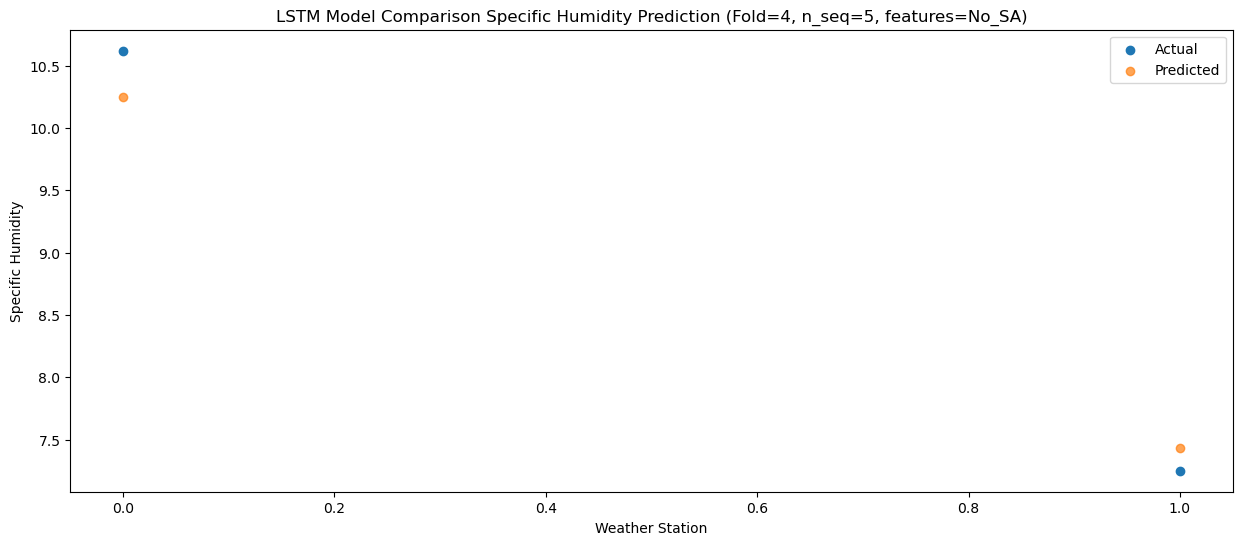

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  10.297964
1                1    7.48   7.482835


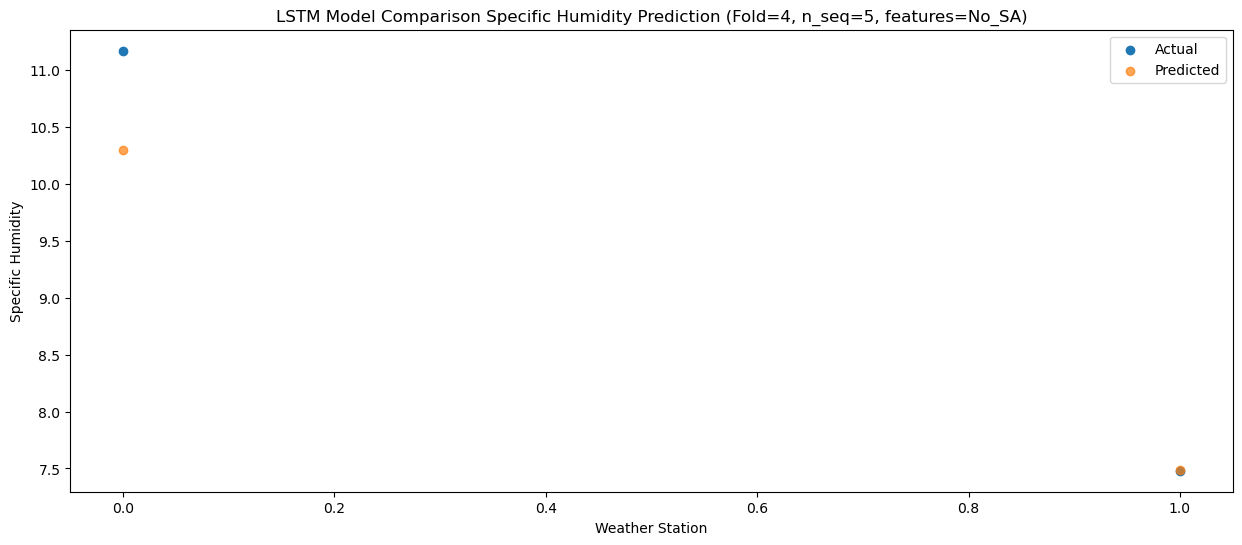

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.84355575  7.98705231]
 [10.49225456  7.65405013]
 [10.6671429   7.85782319]
 [10.2451965   7.43250925]
 [10.29796414  7.48283542]]
Year at t+1:
t+1 SKRMSE: 0.263597
t+1 KRMSE: 0.263597
t+1 MAE: 0.256748
t+1 SKMAPE: 0.026825
t+1 R2_SCORE: 0.975527
t+1 KMAPE: 0.026825
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.412495
t+2 KRMSE: 0.412495
t+2 MAE: 0.350898
t+2 SKMAPE: 0.034580
t+2 R2_SCORE: 0.945689
t+2 KMAPE: 0.034580
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.525308
t+3 KRMSE: 0.525308
t+3 MAE: 0.375340
t+3 SKMAPE: 0.033051
t+3 R2_SCORE: 0.912906
t+3 KMAPE: 0.033051
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.294777
t+4 KRMSE: 0.294777
t+4 MAE: 0.278656
t+4 SKMAPE: 0.030233
t+4 R2_SCORE: 0.969395
t+4 KMAPE: 0.030233
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.616626


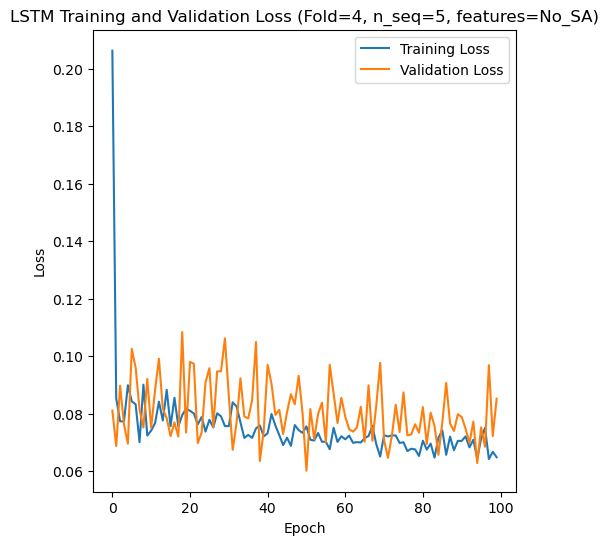

[[0.37133574305150724], [0.548190439042066], [0.6644109443854329], [0.3889101905625925], [0.44332952006093]]
[[array(0.37133574)], [array(0.54819044)], [array(0.66441094)], [array(0.38891019)], [array(0.44332952)]]
[[0.33537451604008695], [0.47056569457054154], [0.5822116643786435], [0.33090958216786426], [0.3398156442791228]]
[[0.03030476634038153], [0.053838054591397864], [0.06934804277911132], [0.0631533248360627], [0.032782662834910097]]
[[0.9437697741058333], [0.906985723314816], [-0.10023802917857205], [0.949602844636173], [0.9372171365695728]]
[[array(0.03030477)], [array(0.05383805)], [array(0.06934804)], [array(0.06315332)], [array(0.03278266)]]
[[array(0.96901679)], [array(0.96939399)], [array(0.79863721)], [array(0.98624743)], [array(0.98967368)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  8.09 

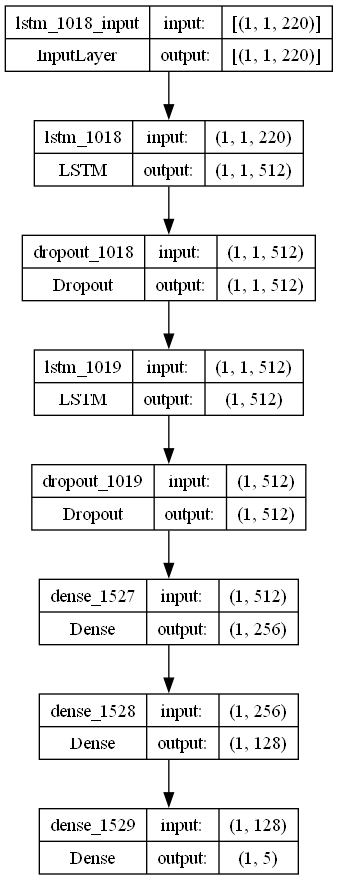

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.017524405379772418
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.1833685786113305

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S5_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)